<h1 style="text-align: center;">LSTM Model for Stock Prediction</h1>

<h3>Import of Libraries</h3>

In [9]:
import os

from typing import Tuple, Dict

import math
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from re import X
import tensorflow as tf

import keras;
from keras_tuner import HyperModel, RandomSearch
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from keras.layers import Dropout

print(keras.__version__)
print(tf.__version__)

2.15.0
2.15.0


<h3>Functions for Loading preprocessed data</h3>

In [10]:
def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

<h3>Functions for preparing data for LSTM model</h3>

In [11]:
def extract_features_required_for_training(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Extracts features required for training.
    """
    return df[features]


def split_data_into_training_and_test_sets(df: pd.DataFrame, window_start: int, window_end: int, test_size: float, columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, float]]:
    """
    Normalizes the entire data set, then splits it into training and test sets based on the given ratio.
    """
    data_count = window_end - window_start
    test_data_count = int(data_count * test_size)

    end_of_training_data = window_start + test_data_count

    df, max_values = normalize_data(df, columns, window_start, window_end)

    return df.iloc[window_start : end_of_training_data], df.iloc[end_of_training_data : window_end], max_values


def normalize_data(df: pd.DataFrame, columns: list[str], start: int, end: int):
    """
    Normalizes the data in the given segment.
    """
    max_values = {}
    for column in columns:
        max_value = df.iloc[start:end][column].max()
        df.loc[start:end, column] = df.loc[start:end, column] / max_value
        max_values[column] = max_value

    return df, max_values


def denormalize_data(data_array: np.ndarray, columns: list[str], max_values: dict):
    """
    Denormalizes the data in the given segment.
    """
    for column in columns:
        data_array[:] = data_array[:] * max_values[column]

    return data_array


def create_dataset(dataset: pd.DataFrame, time_step = 1) -> tuple[np.ndarray, np.ndarray]:
    """
    Creates a dataset.
    """
    dataX,dataY = [],[]

    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset.iloc[i:(i+time_step), 0])
        dataY.append(dataset.iloc[i + time_step, 0])

    return np.array(dataX),np.array(dataY)

<h3>Function for Building the LSTM model</h3>

In [12]:
def build_model(input_shape):
    """
    Builds the LSTM model.
    """
    model = Sequential()
    model.add(LSTM(75, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))

    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(75))
    model.add(Dropout(0.1))

    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.1))

    model.add(Dense(512, activation="relu")) 
    model.add(Dropout(0.1))

    model.add(Dense(1, activation="relu"))
    
    model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["mae", 'mape'])
    model.summary()

    return model

<h3>Function for Hyperparameter optimization</h3>

In [13]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=25, max_value=75, step=10), 
                    return_sequences=True, 
                    input_shape=self.input_shape))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))

        for i in range(hp.Int('layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=25, max_value=75, step=10), 
                        return_sequences=True))
            model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.4, step=0.1)))

        model.add(LSTM(units=hp.Int('units_final', min_value=128, max_value=512, step=32)))
        model.add(Dropout(hp.Float('dropout_final', min_value=0.1, max_value=0.4, step=0.1)))

        for i in range(hp.Int('dense_layers', 1, 2)):
            model.add(Dense(hp.Int('dense_units_' + str(i), min_value=128, max_value=512, step=64), 
                            activation=hp.Choice('dense_activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])))
            model.add(Dropout(hp.Float('dense_dropout_' + str(i), min_value=0.1, max_value=0.4, step=0.1)))

        model.add(Dense(1, activation="relu"))

        model.compile(loss="mse", 
                    optimizer=keras.optimizers.Adam(
                        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                    metrics=["mae", 'mape'])

        return model

<h3>Functions for representing data</h3>

In [14]:
def forecast_on_whole_dataset(model, data, max_values, time_step, forecast_size):
    """
    Forecasts the data.
    """
    forecast = []
    for i in range(forecast_size):
        forecast.append(model.predict(data))
        data = np.append(data, forecast[-1])
        data = np.delete(data, 0)
        data = data.reshape(1, time_step, 1)
    forecast = np.array(forecast)
    forecast = forecast.reshape(forecast_size, 1)
    forecast = denormalize_data(forecast, ["Close"], max_values)
    return forecast

def plot_data(loaded_data, title: str, xlabel: str, ylabel: str, datacolumn: str):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    plt.plot(loaded_data[datacolumn])
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.show()


def plot_data_list(loaded_data_list, title: str, xlabel: str, ylabel: str, datacolumns: list):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    for loaded_data, datacolumn in zip(loaded_data_list, datacolumns):
        plt.plot(loaded_data, label=datacolumn)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend()
    plt.show()
    

def plot_all_data(all_actual, all_predictions, title, xlabel, ylabel, legend_pred, legend_act):
    colors = ['red', 'yellow', 'pink', 'gray', 'orange']  # List of colors to cycle through
    plt.figure(figsize=(14, 8))

    # Concatenate all actual data and plot it in one color
    all_actual_concat = np.concatenate(all_actual)
    plt.plot(all_actual_concat, color='lightblue', label=legend_act)

    # Plot each predicted segment with a different color
    start = 0
    for i, predictions in enumerate(all_predictions):
        end = start + len(predictions)
        x = range(start, end)
        color = colors[i % len(colors)]  # Cycle through colors
        plt.plot(x, predictions, color=color, label=legend_pred + ' ' + str(i+1))
        start = end

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

<h3>Function for fiting the model</h3>

In [15]:
def lstm_prediction(file: str):
    file_name = file.split("/")[-1]
    file_name_without_extension = file_name.split(".")[0]

    loaded_data = import_data_from_csv(file)
    extracted_data = extract_features_required_for_training(loaded_data, ["Adj Close"])

    time_step = 5
    number_of_intervals = 5
    percentage_of_test_interval_data = 0.8

    interval_size = int(extracted_data.shape[0] / number_of_intervals)

    X_training_data, Y_training_data = [], []
    X_test_data, Y_test_data = [], []
    X_all_data, Y_all_data = [], []
    max_values_list = []

    for i in range(number_of_intervals):
        start = i * interval_size
        end = start + interval_size

        if(i == number_of_intervals - 1):
            end = extracted_data.shape[0]

        training_data_interval, test_data_interval, max_values = split_data_into_training_and_test_sets(extracted_data, start, end, percentage_of_test_interval_data, ["Adj Close"])
        
        X_train, Y_train =  create_dataset(training_data_interval, time_step)
        X_test, Y_test =  create_dataset(test_data_interval, time_step)
        X_all = np.concatenate((X_train, X_test))
        Y_all = np.concatenate((Y_train, Y_test))

        if(i != 0):
            X_train = np.concatenate((X_test_data[i - 1], X_train))
            Y_train = np.concatenate((Y_test_data[i - 1], Y_train))

        X_training_data.append(X_train)
        Y_training_data.append(Y_train)

        X_test_data.append(X_test)
        Y_test_data.append(Y_test)

        X_all_data.append(X_all)
        Y_all_data.append(Y_all)

        max_values_list.append(max_values)

    X_train_shape = (X_training_data[0].shape[1], 1)
    #lstm_model = build_model(X_train_shape)

    predictions_list = []
    actuals_list = []

    all_actual_for_intervals_list = []
    all_predictions_for_intervals_list = []

    for i in range(number_of_intervals):
        X_training_data_interval = X_training_data[i]
        Y_training_data_interval = Y_training_data[i]
        X_test_data_interval = X_test_data[i]
        Y_test_data_interval = Y_test_data[i]
        X_all_data_interval = X_all_data[i]
        Y_all_data_interval = Y_all_data[i]
        
        file_path = "checkpoints/" + file_name_without_extension + "/lstm-" + str(i + 1) + ".keras"
        print(file_path)
        if(os.path.exists(file_path)):
            lstm_model = load_model(file_path)
            lstm_model.summary()

        else:
            file_path_previos = "checkpoints/" + file_name_without_extension + "/lstm-" + str(i) + ".keras"

            if(os.path.exists(file_path_previos)):
                lstm_model = load_model(file_path_previos)

            X_training_data_interval = np.reshape(X_training_data_interval, (X_training_data_interval.shape[0], X_training_data_interval.shape[1], 1))

            ###Before hyperparameter tuning
            #t_hist = lstm_model.fit(X_training_data_interval, Y_training_data_interval, batch_size = 15, epochs = 50)
            
            ###Hyperparameter tuning
            hypermodel = LSTMHyperModel(input_shape=X_train_shape)
            tuner = RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=15,
                executions_per_trial=2,
                directory='tuning_results',
                project_name='lstm'+file_name_without_extension+str(i))

            tuner.search(X_training_data_interval, Y_training_data_interval,
                        epochs=20,
                        validation_data=(X_test_data_interval, Y_test_data_interval))

            best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

            lstm_model = tuner.hypermodel.build(best_hps)
            t_hist = lstm_model.fit(X_training_data_interval, Y_training_data_interval, batch_size = 15, epochs = 50)
            
            pd.DataFrame(t_hist.history).plot(figsize=(8,5))
            plt.show()

            lstm_model.save(file_path)
        
        X_test_data_interval = np.reshape(X_test_data_interval, (X_test_data_interval.shape[0], X_test_data_interval.shape[1] ,1))
        predictions = lstm_model.predict(X_test_data_interval)

        denormalized_predictions = denormalize_data(predictions, ["Adj Close"], max_values_list[i])
        denormalized_actuals = denormalize_data(Y_test_data_interval, ["Adj Close"], max_values_list[i])
        plot_data_list([denormalized_predictions.flatten(), denormalized_actuals.flatten()], 'Predictions vs Actual for ' + str(i+1) + '. iteration of ' + file_name_without_extension, 'Date', 'Adj Close Price USD ($)', ['Predictions', 'Actual'])

        rmse = np.sqrt(np.mean(((predictions - Y_test_data_interval) ** 2)))
        mae = np.mean(np.abs(predictions - Y_test_data_interval))
        print("Value of RSME for interval " + str(i + 1) + " is: " + str(rmse))
        print("Value of MAE for interval " + str(i + 1) + " is: " + str(mae))

        X_all_data_interval = np.reshape(X_all_data_interval, (X_all_data_interval.shape[0], X_all_data_interval.shape[1] ,1))
        all_predictions_for_interval = lstm_model.predict(X_all_data_interval)

        denormalized_predictions_for_interval = denormalize_data(all_predictions_for_interval, ["Adj Close"], max_values_list[i])
        denormalized_actuals_for_interval = denormalize_data(Y_all_data_interval, ["Adj Close"], max_values_list[i])

        all_actual_for_intervals_list.append(denormalized_actuals_for_interval)
        all_predictions_for_intervals_list.append(denormalized_predictions_for_interval)

        predictions_list = np.concatenate((predictions_list, denormalized_predictions.flatten()))
        actuals_list = np.concatenate((actuals_list, denormalized_actuals.flatten()))


    plot_data_list([predictions_list, actuals_list], 'Predictions vs Actual for ' + file_name_without_extension, 'Date', 'Adj Close Price USD ($)', ['Predictions', 'Actual'])
    print("NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.")

    plot_all_data(all_actual_for_intervals_list, all_predictions_for_intervals_list, 'Predictions vs Actual for ' + file_name_without_extension, 'Date', 'Adj Close Price USD ($)', 'Predictions', 'Actual')

<h3>Main function</h3>

Processing file: AAPL.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/AAPL/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 35)             5180      
                                                                 
 dropout_5 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 25)             6100      
                                                                 
 dropout_6 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 224)               224000    
                                                                 
 dropout_7 (Dropout)         (None, 224)               0         
                                                                 
 dense_3 (Dense)        

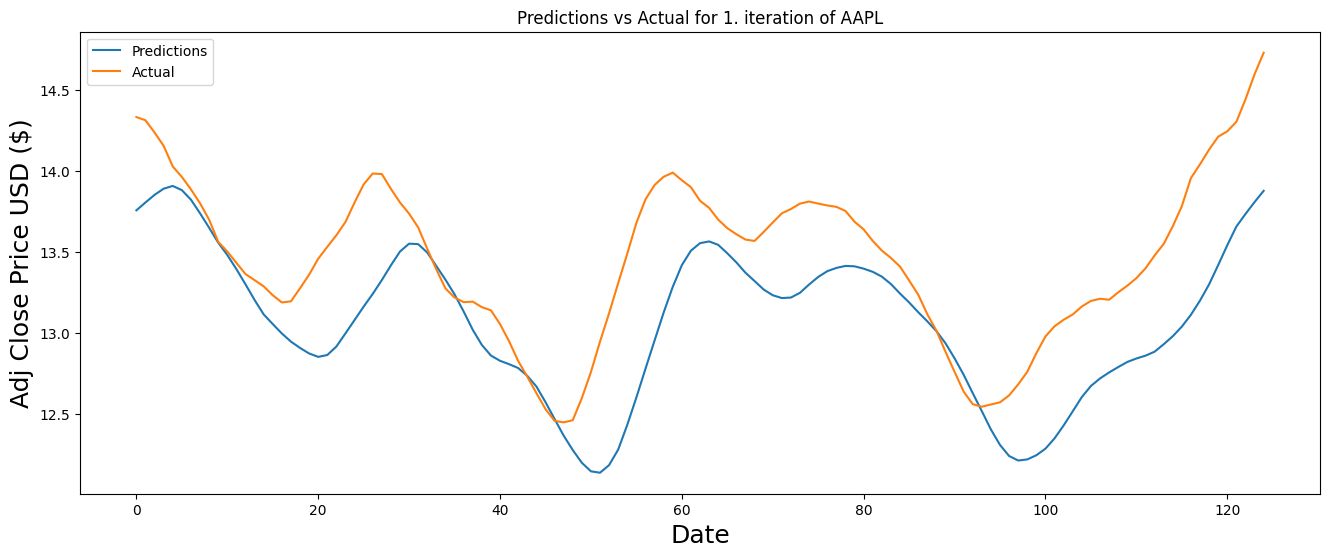

Value of RSME for interval 1 is: 0.7791818468182121
Value of MAE for interval 1 is: 0.6280544045866029
20/20 [==============================] - 0s 5ms/step
checkpoints/AAPL/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 35)             5180      
                                                                 
 dropout_5 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 75)             33300     
                                                                 
 dropout_6 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_5 (LSTM)               (None, 224)               268800    
                                                                 


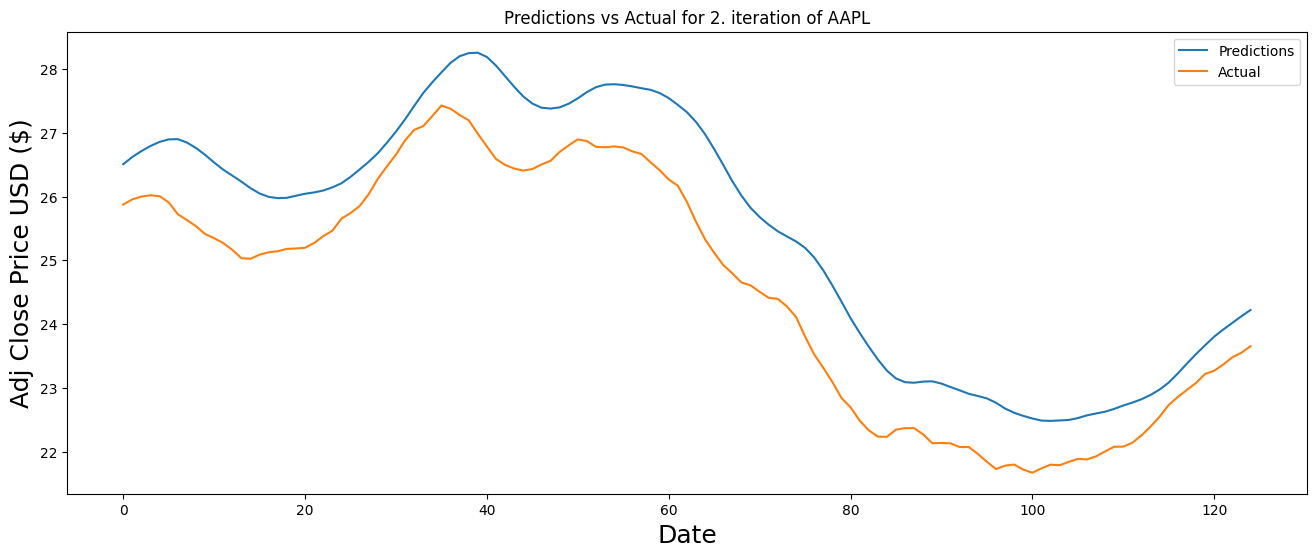

Value of RSME for interval 2 is: 2.856381490820478
Value of MAE for interval 2 is: 2.3287059472131393
20/20 [==============================] - 0s 6ms/step
checkpoints/AAPL/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_6 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 65)             36660     
                                                                 
 dropout_7 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_5 (LSTM)               (None, 192)               198144    
                                                                 
 

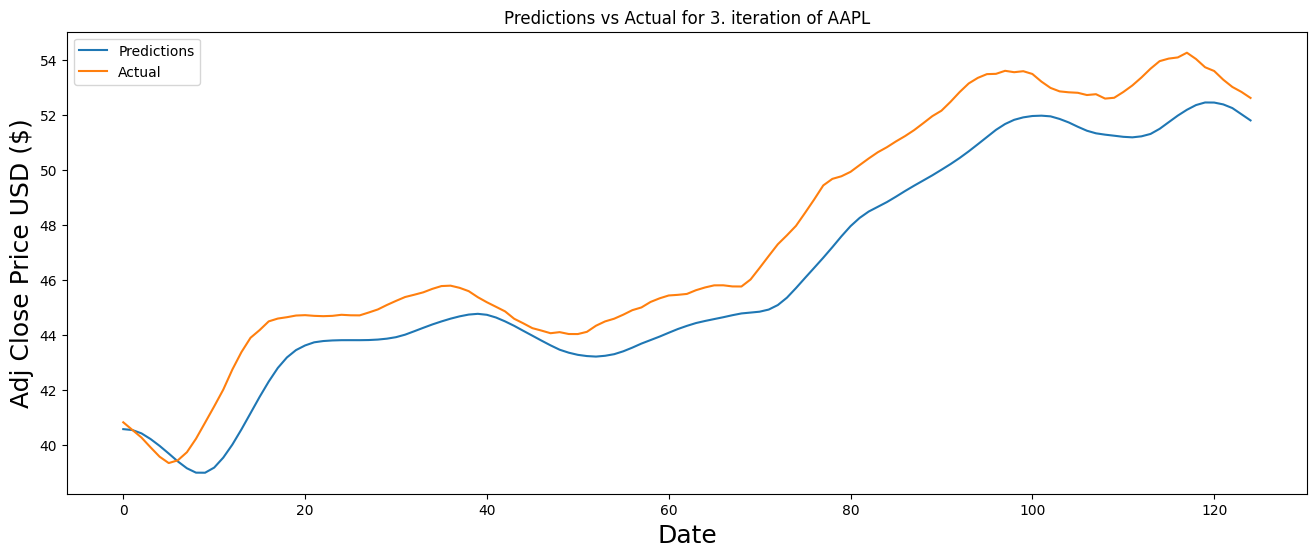

Value of RSME for interval 3 is: 6.0691053114552975
Value of MAE for interval 3 is: 4.8724998942260696
20/20 [==============================] - 0s 6ms/step
checkpoints/AAPL/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 45)             8460      
                                                                 
 dropout_7 (Dropout)         (None, 5, 45)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 45)             16380     
                                                                 
 dropout_8 (Dropout)         (None, 5, 45)             0         
                                                                 
 lstm_7 (LSTM)               (None, 384)               660480    
                                                                 


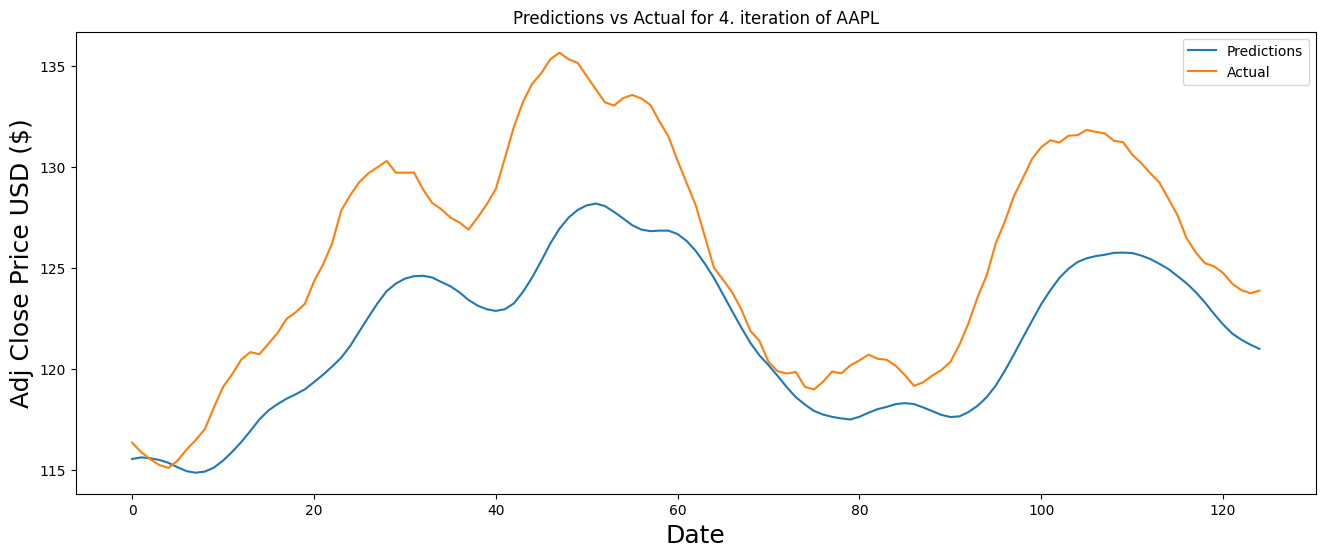

Value of RSME for interval 4 is: 7.865947364005805
Value of MAE for interval 4 is: 6.470776921506842
20/20 [==============================] - 0s 8ms/step
checkpoints/AAPL/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_5 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 55)             28820     
                                                                 
 dropout_6 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_6 (LSTM)               (None, 480)               1029120   
                                                                 
 d

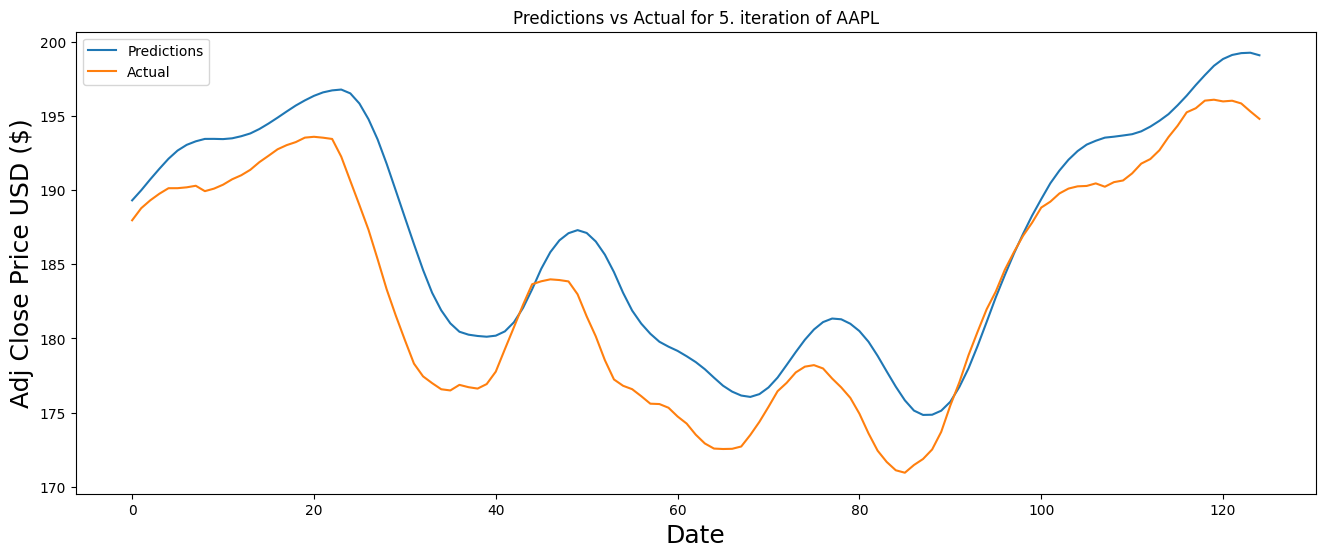

Value of RSME for interval 5 is: 11.270676291889886
Value of MAE for interval 5 is: 9.199825768675996
21/21 [==============================] - 0s 8ms/step


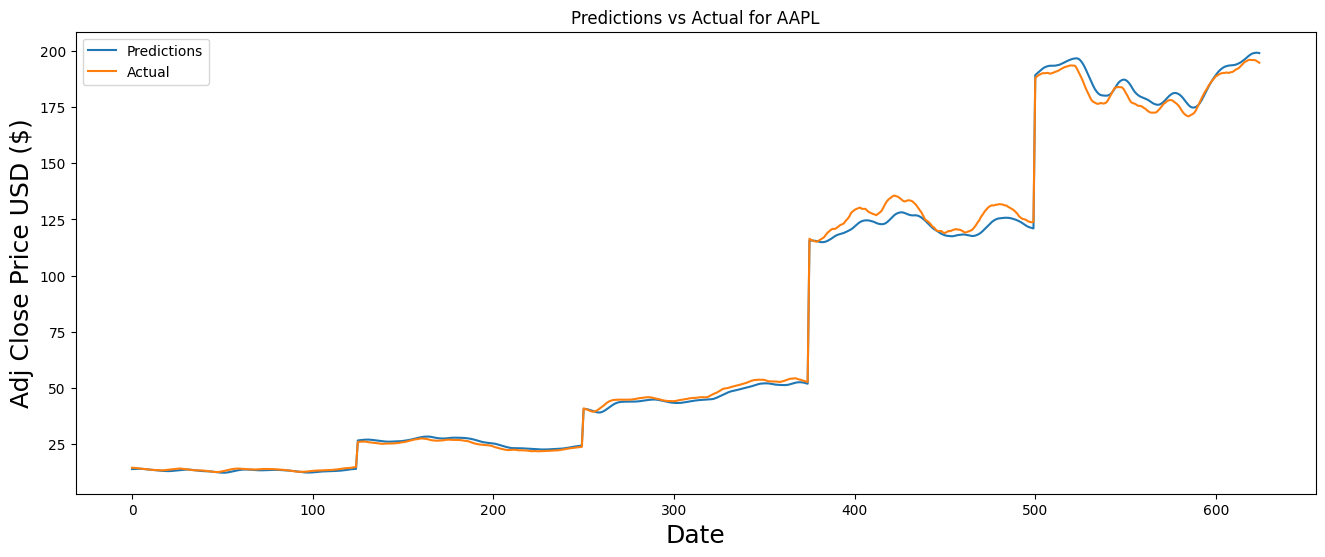

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


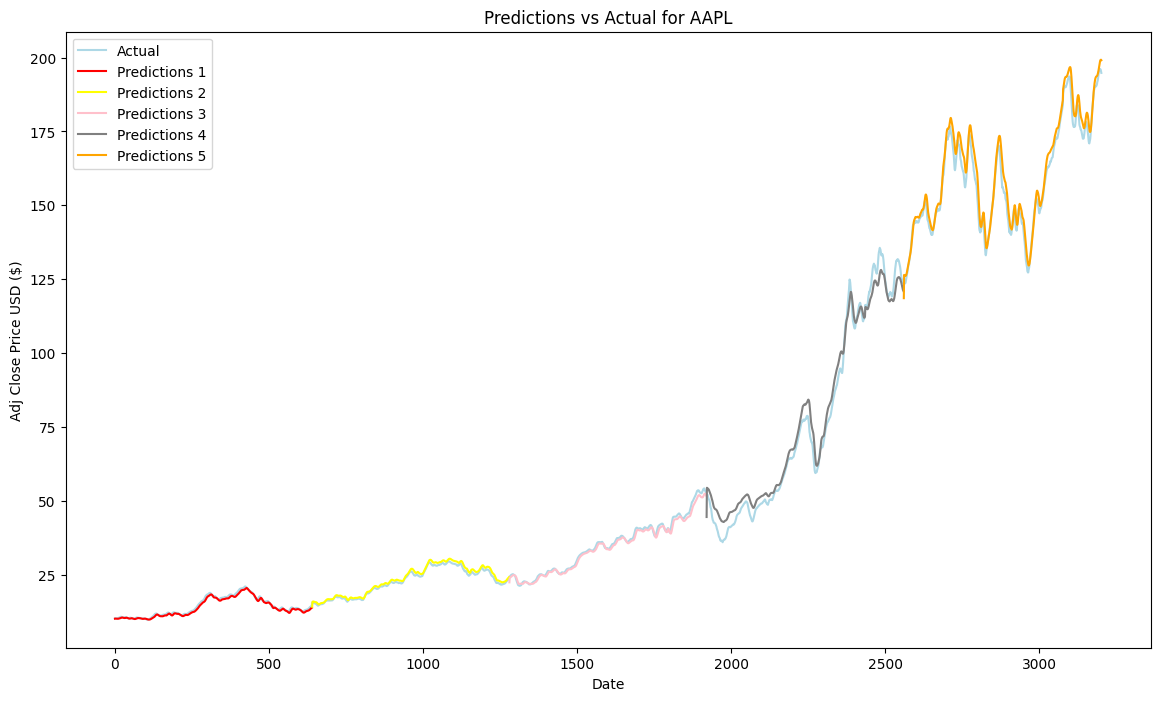

Processing file: GOOG.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/GOOG/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_6 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 25)             10100     
                                                                 
 dropout_7 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               78848     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)        

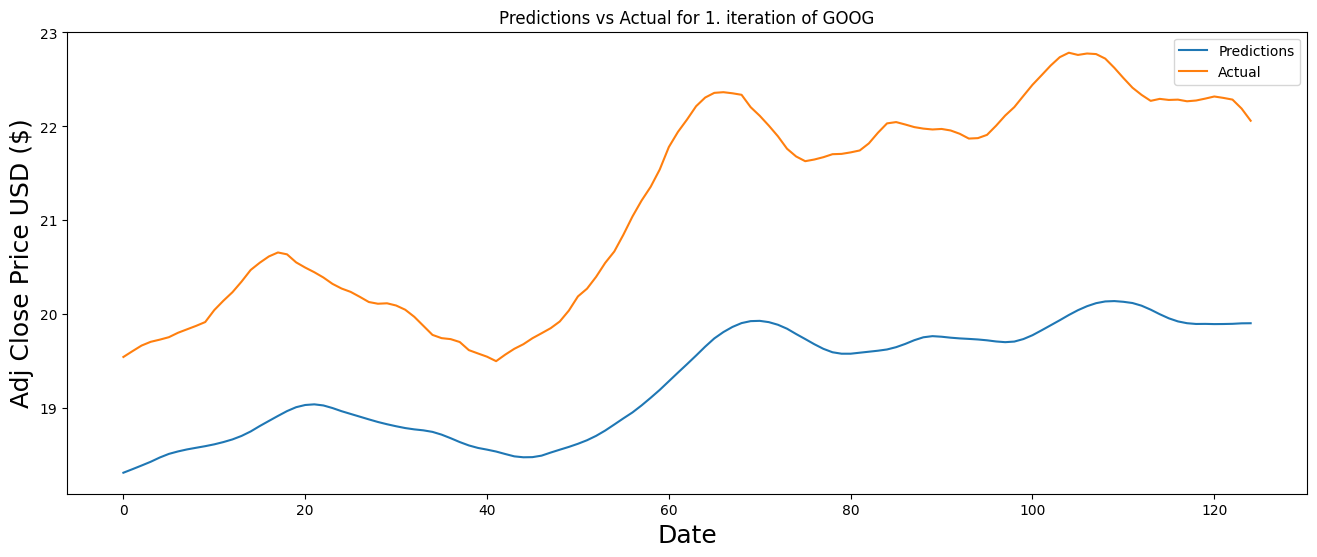

Value of RSME for interval 1 is: 2.2631310396635076
Value of MAE for interval 1 is: 1.9299604477021484
20/20 [==============================] - 0s 5ms/step
checkpoints/GOOG/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 35)             5180      
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 45)             14580     
                                                                 
 dropout_7 (Dropout)         (None, 5, 45)             0         
                                                                 
 lstm_7 (LSTM)               (None, 384)               660480    
                                                                 


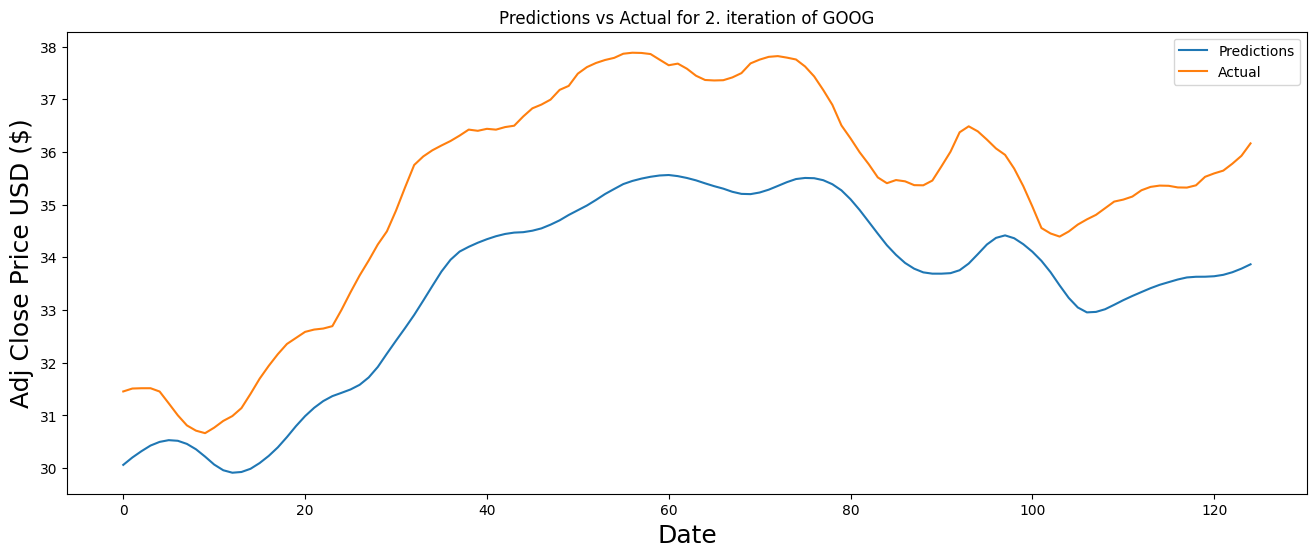

Value of RSME for interval 2 is: 3.2962795434679544
Value of MAE for interval 2 is: 2.725606530506113
20/20 [==============================] - 0s 8ms/step
checkpoints/GOOG/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 25)             2700      
                                                                 
 dropout_5 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 35)             8540      
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 25)             6100      
                                                                 
 

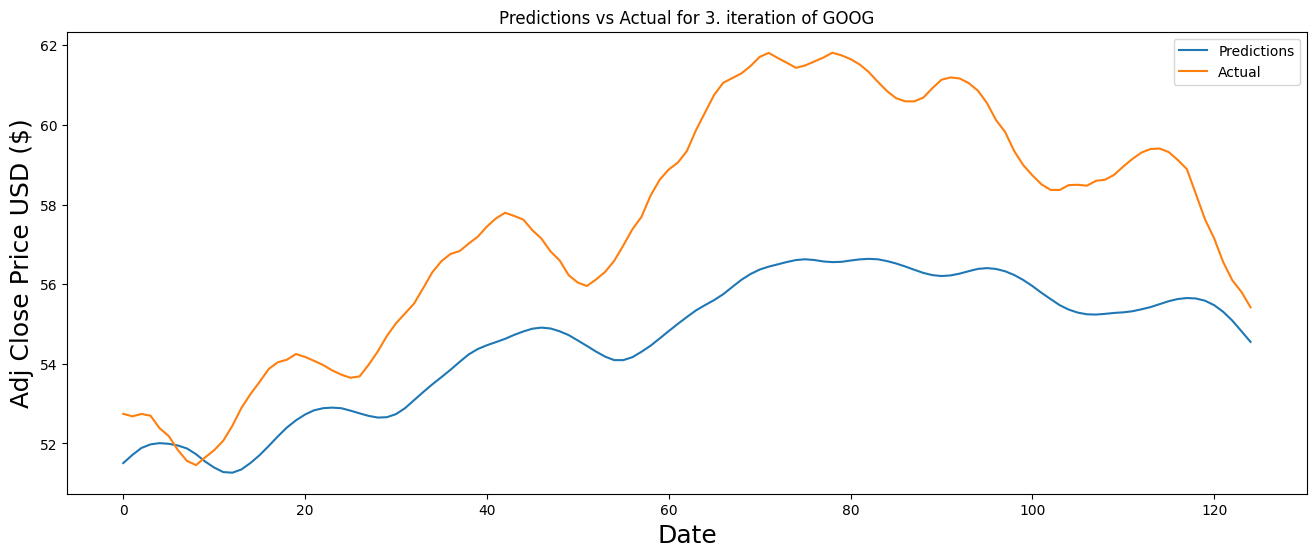

Value of RSME for interval 3 is: 4.5245493393955485
Value of MAE for interval 3 is: 3.79166494479914
20/20 [==============================] - 0s 7ms/step
checkpoints/GOOG/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 25)             2700      
                                                                 
 dropout_6 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 55)             17820     
                                                                 
 dropout_7 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               319488    
                                                                 
 d

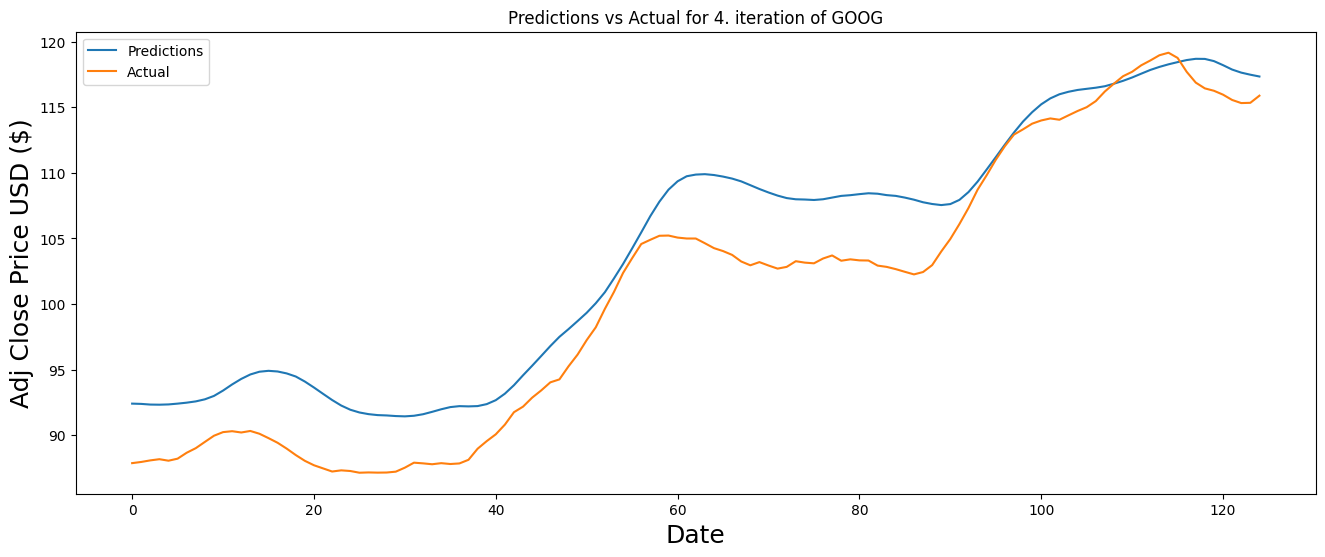

Value of RSME for interval 4 is: 14.715647463232605
Value of MAE for interval 4 is: 12.134933785563632
20/20 [==============================] - 0s 6ms/step
checkpoints/GOOG/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 35)             5180      
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 75)             33300     
                                                                 
 dropout_7 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 65)             36660     
                                                                 


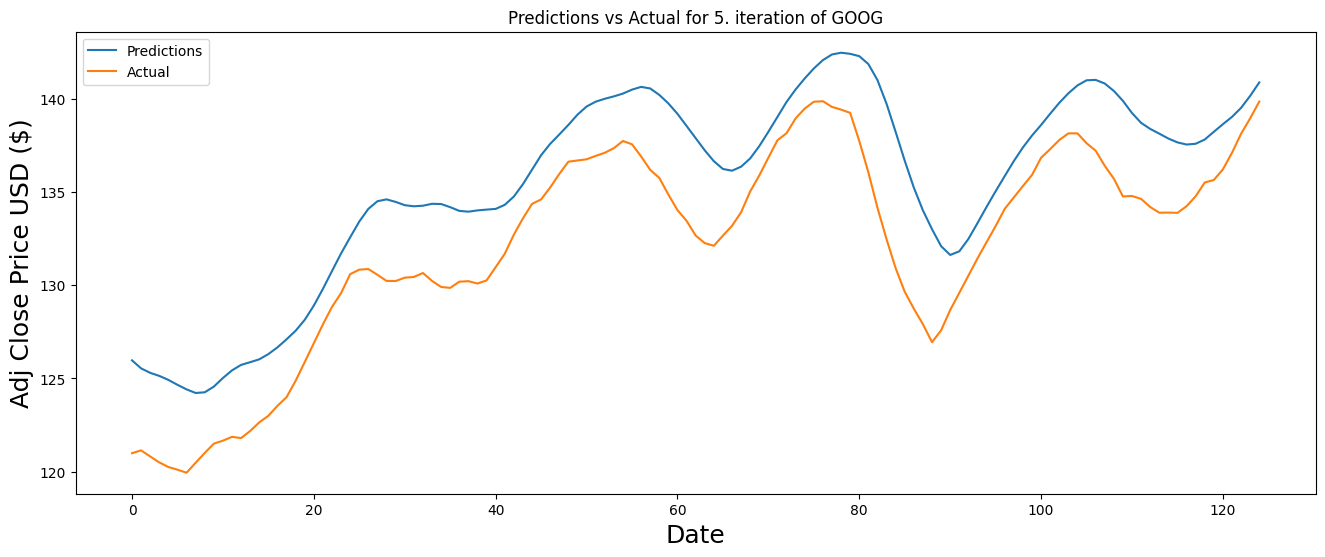

Value of RSME for interval 5 is: 8.236600530064695
Value of MAE for interval 5 is: 6.5541330975543
21/21 [==============================] - 0s 6ms/step


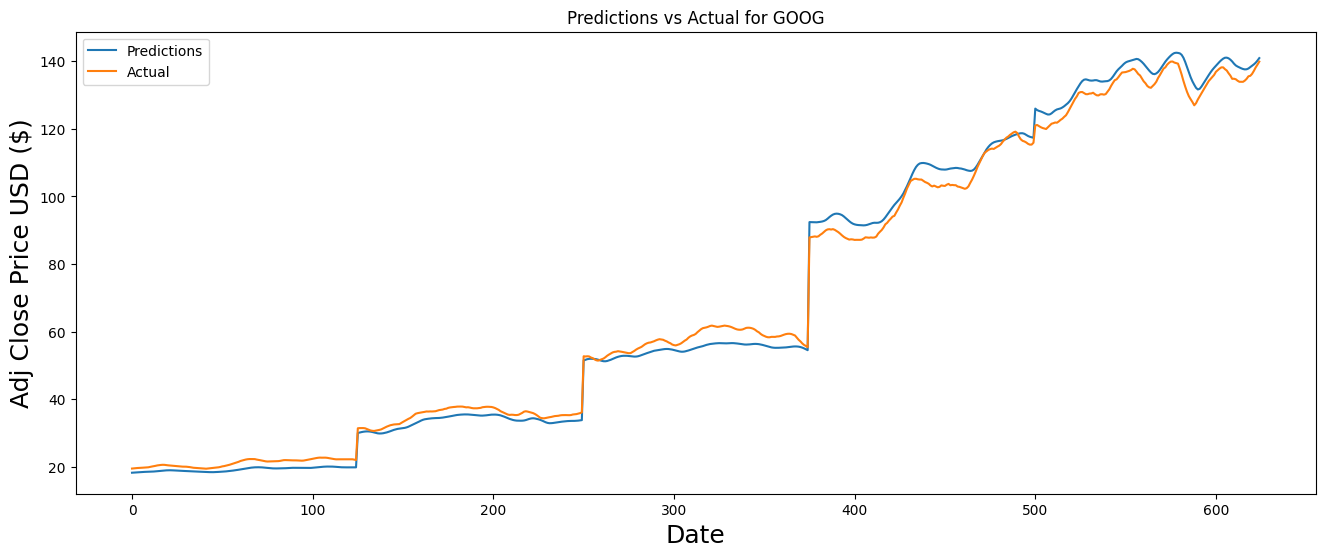

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


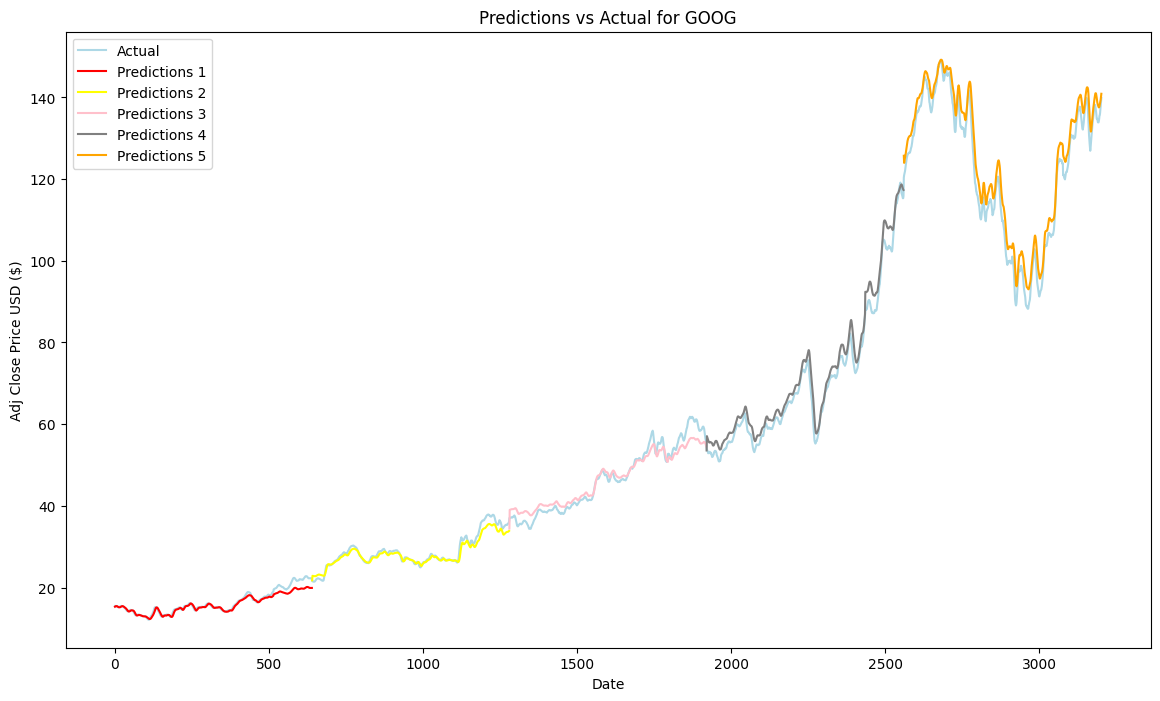

Processing file: MSFT.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/MSFT/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_8 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 75)             42300     
                                                                 
 dropout_9 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 25)             10100     
                                                                 
 dropout_10 (Dropout)        (None, 5, 25)             0         
                                                                 
 lstm_8 (LSTM)          

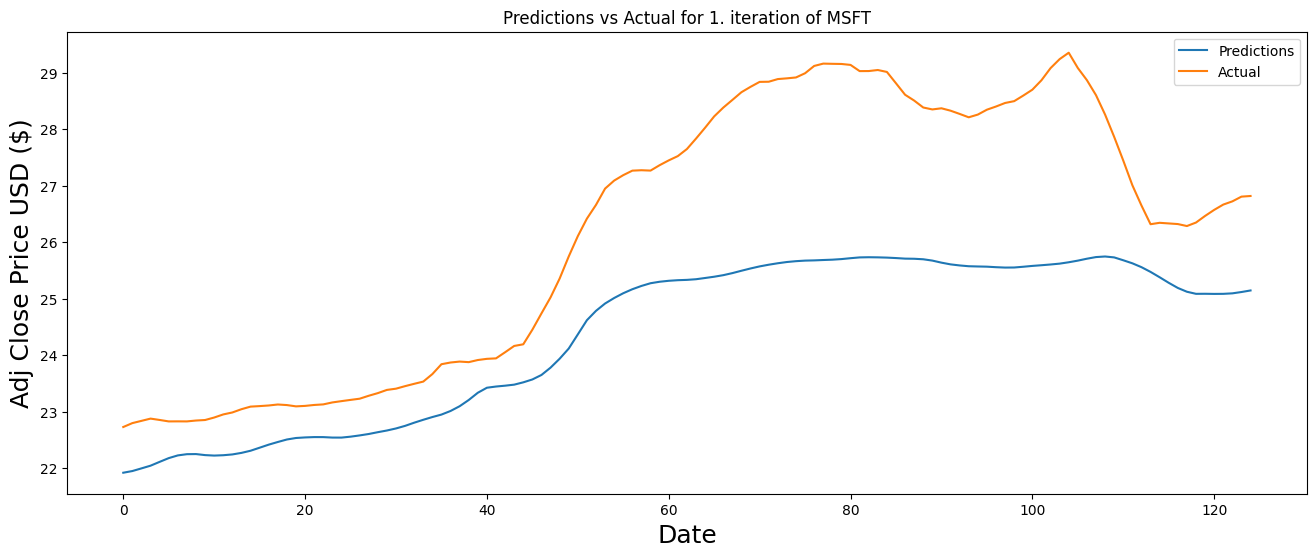

Value of RSME for interval 1 is: 3.30613539530478
Value of MAE for interval 1 is: 2.8025276901280614
20/20 [==============================] - 0s 9ms/step
checkpoints/MSFT/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_8 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 75)             45300     
                                                                 
 dropout_9 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               104448    
                                                                 
 d

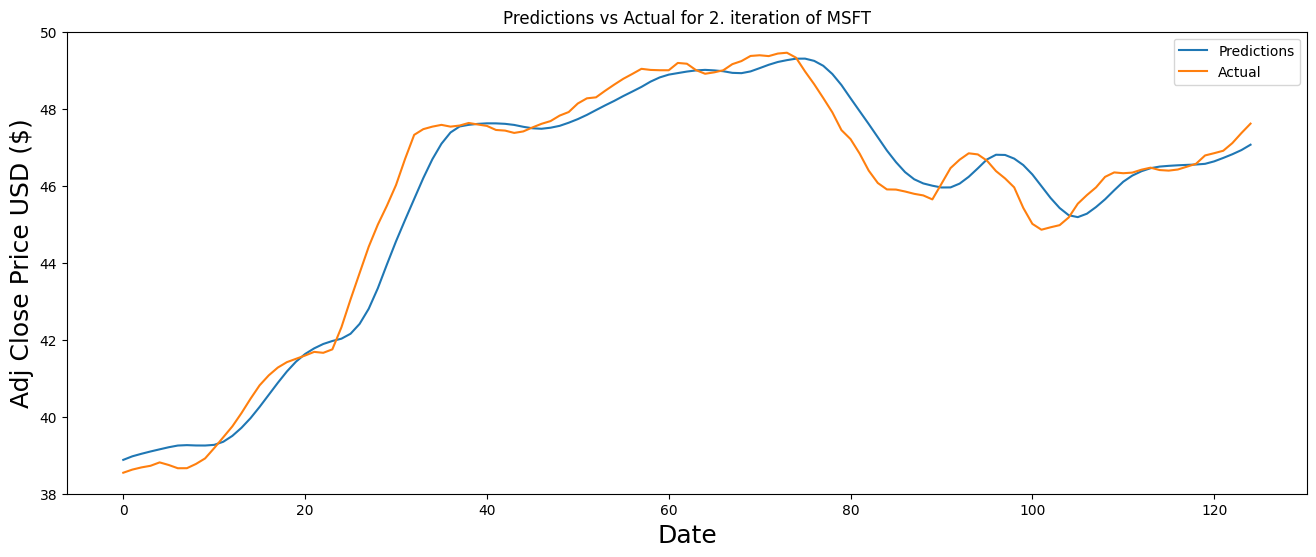

Value of RSME for interval 2 is: 4.4681563296474405
Value of MAE for interval 2 is: 3.3658709360133474
20/20 [==============================] - 0s 5ms/step
checkpoints/MSFT/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 55)             12540     
                                                                 
 dropout_7 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 65)             31460     
                                                                 
 dropout_8 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               329728    
                                                                 


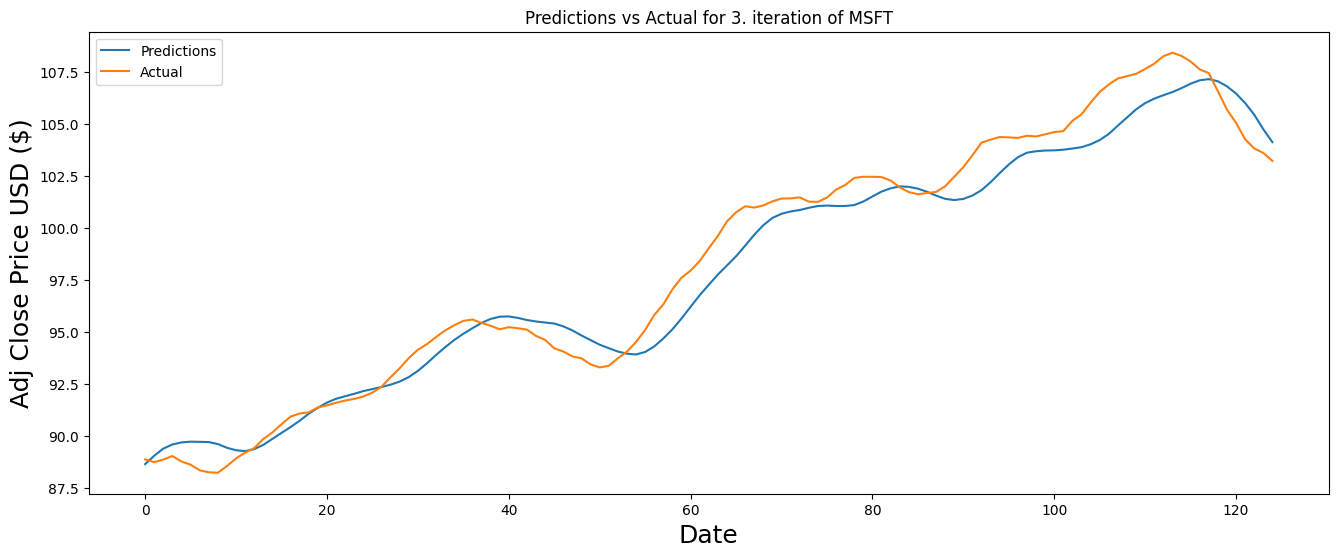

Value of RSME for interval 3 is: 8.296794013763963
Value of MAE for interval 3 is: 6.745384850530861
20/20 [==============================] - 0s 7ms/step
checkpoints/MSFT/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 25)             2700      
                                                                 
 dropout_7 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 35)             8540      
                                                                 
 dropout_8 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_6 (LSTM)               (None, 224)               232960    
                                                                 
 d

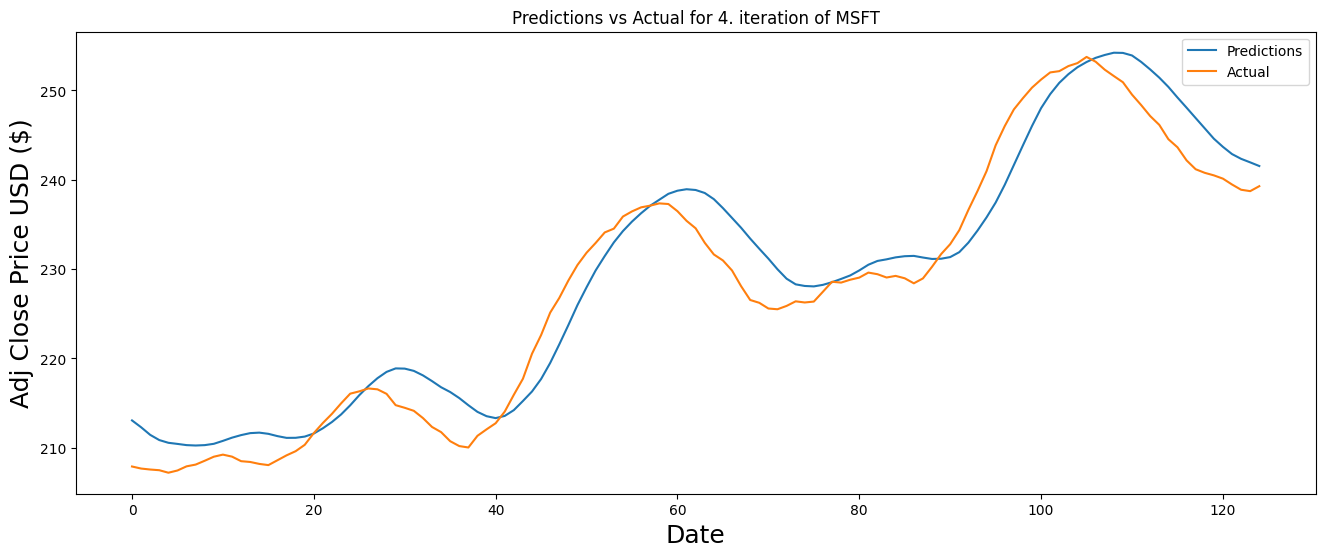

Value of RSME for interval 4 is: 19.900496235581922
Value of MAE for interval 4 is: 16.153478398104316
20/20 [==============================] - 0s 6ms/step
checkpoints/MSFT/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_4 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 75)             45300     
                                                                 
 dropout_5 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 45)             21780     
                                                                 


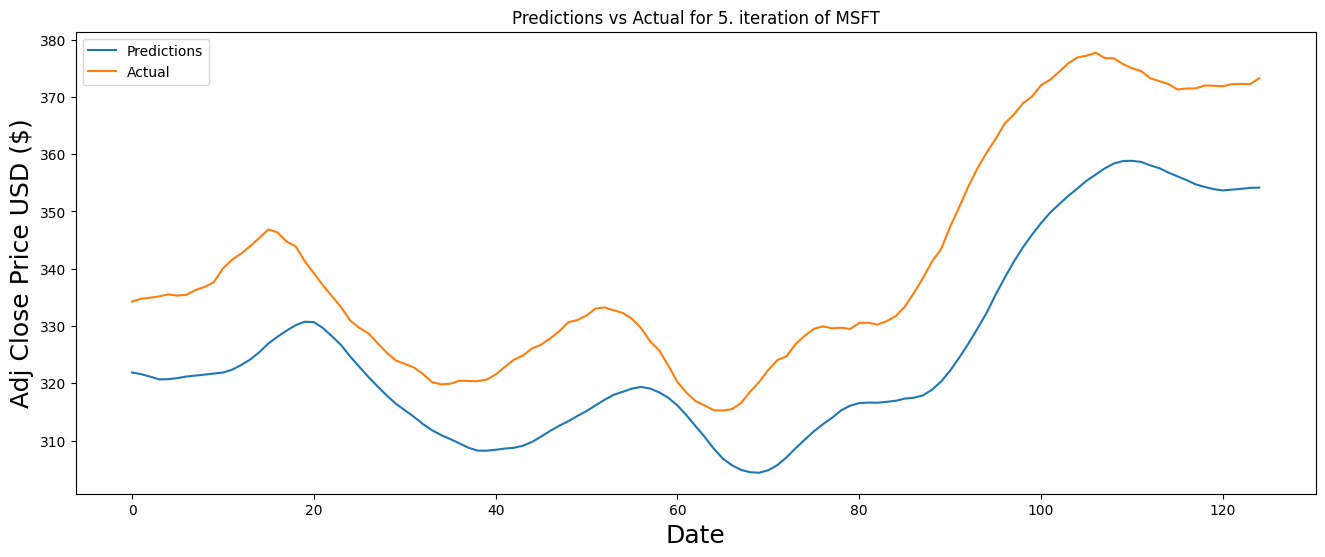

Value of RSME for interval 5 is: 30.07103758043125
Value of MAE for interval 5 is: 24.052410586882704
21/21 [==============================] - 0s 9ms/step


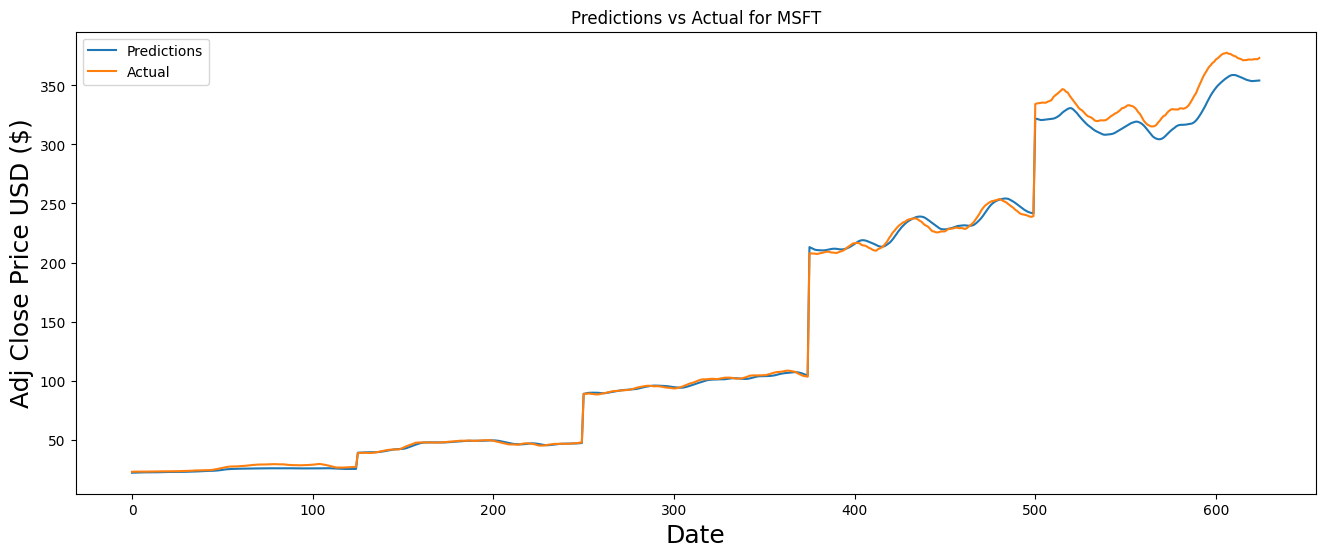

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


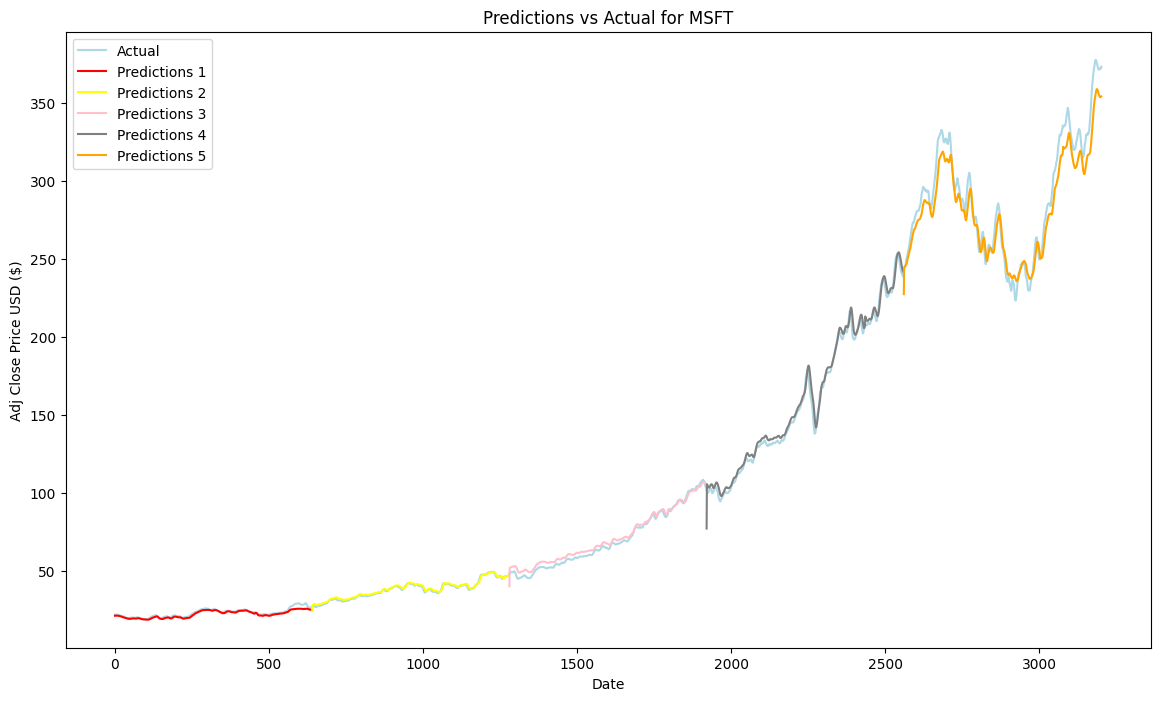

Processing file: NFLX.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/NFLX/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_6 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 65)             36660     
                                                                 
 dropout_7 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_7 (LSTM)               (None, 192)               198144    
                                                                 
 dropout_8 (Dropout)         (None, 192)               0         
                                                                 
 dense_2 (Dense)        

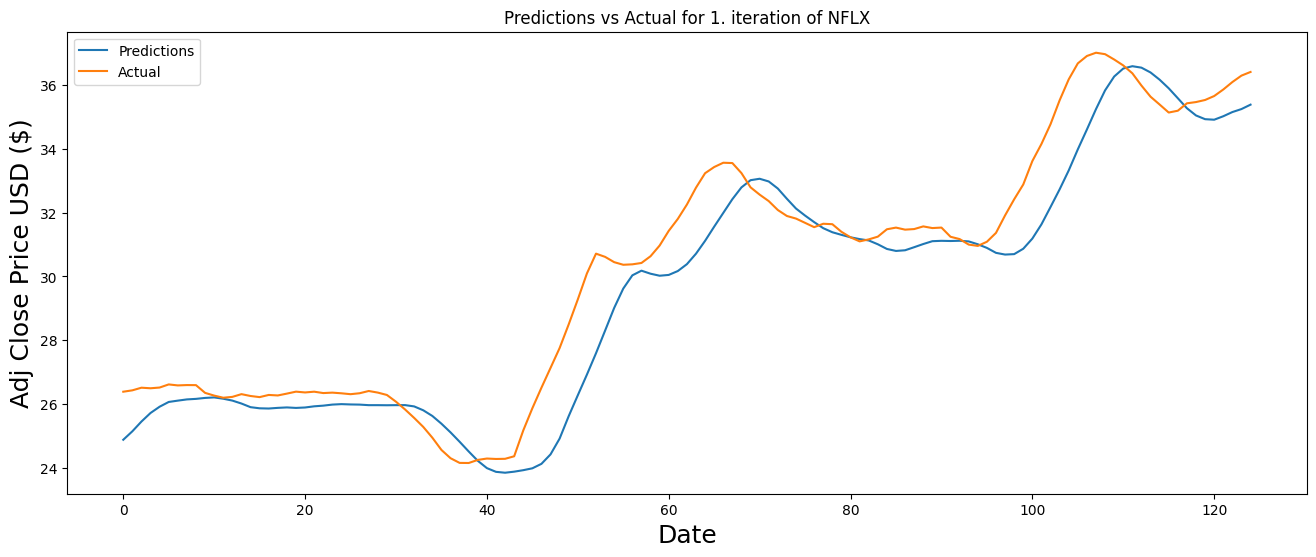

Value of RSME for interval 1 is: 5.472615339624317
Value of MAE for interval 1 is: 4.402290420634463
20/20 [==============================] - 0s 6ms/step
checkpoints/NFLX/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 65)             34060     
                                                                 
 dropout_7 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33280     
                                                                 
 d

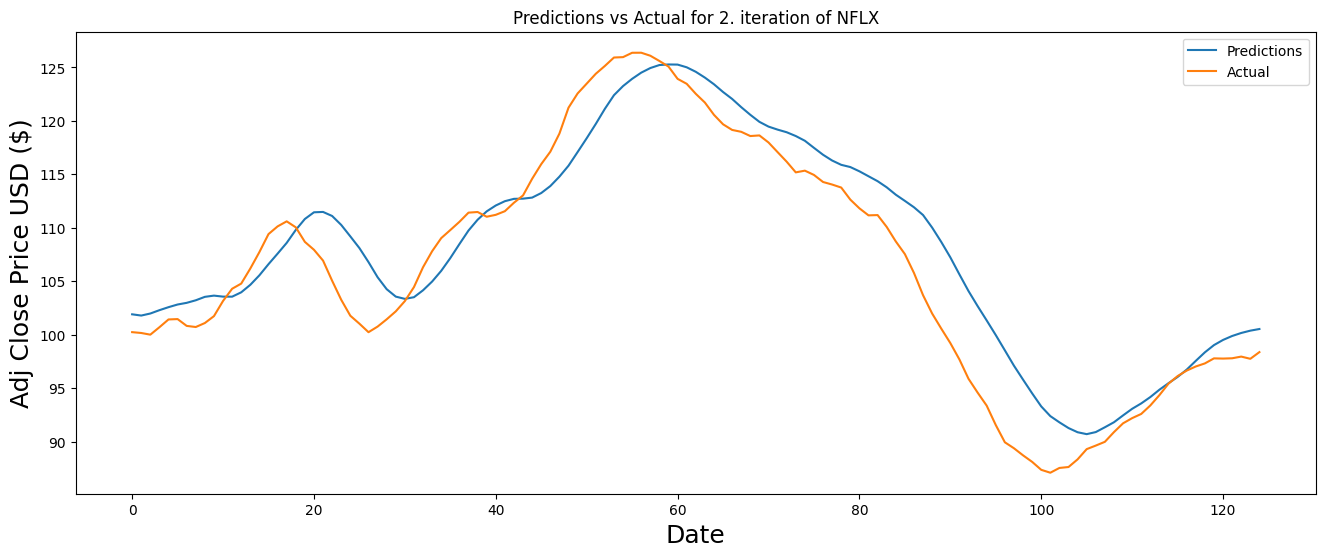

Value of RSME for interval 2 is: 14.761831592663565
Value of MAE for interval 2 is: 12.03354867361011
20/20 [==============================] - 0s 5ms/step
checkpoints/NFLX/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_4 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 65)             34060     
                                                                 
 dropout_5 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_5 (LSTM)               (None, 352)               588544    
                                                                 
 

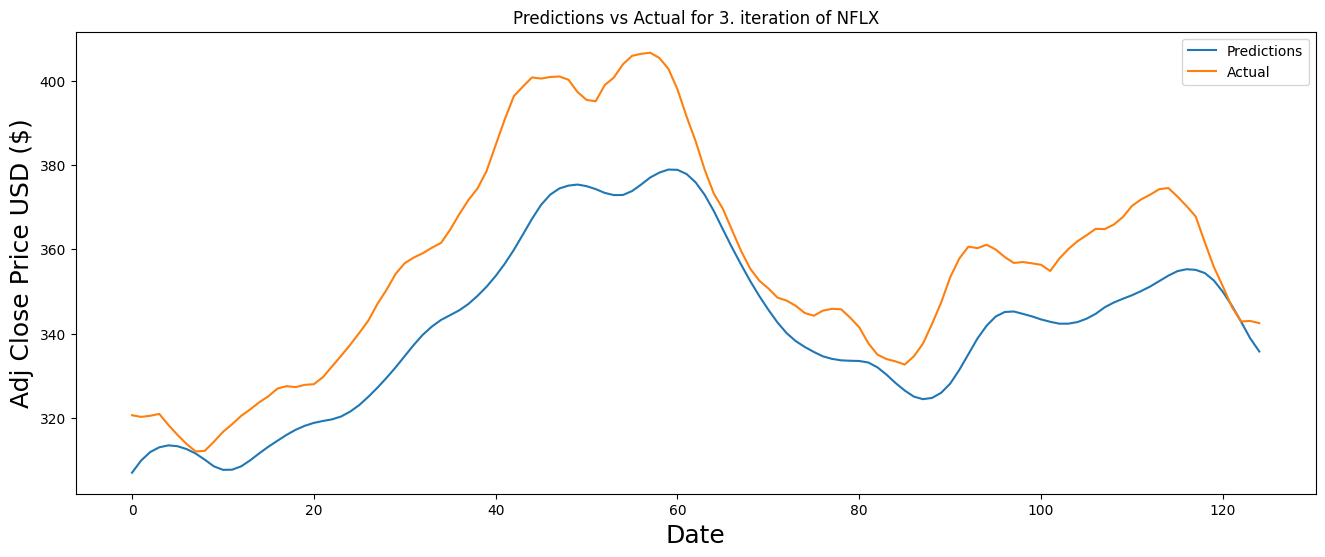

Value of RSME for interval 3 is: 36.05316481889454
Value of MAE for interval 3 is: 28.936035221685
20/20 [==============================] - 0s 7ms/step
checkpoints/NFLX/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 55)             26620     
                                                                 
 dropout_7 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_5 (LSTM)               (None, 384)               675840    
                                                                 
 dro

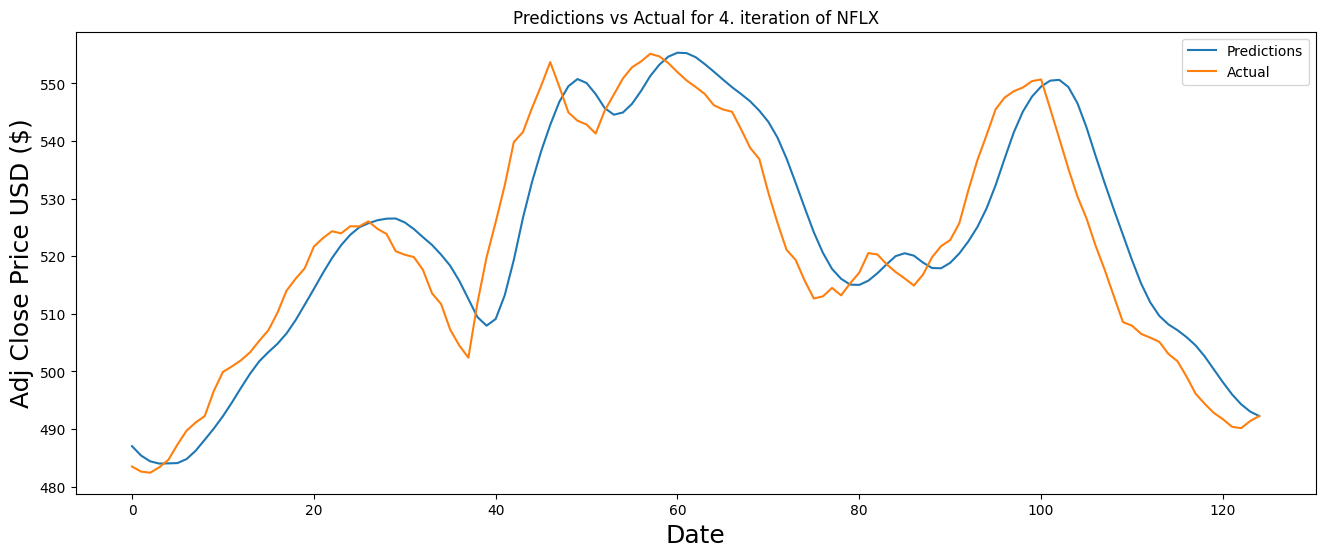

Value of RSME for interval 4 is: 28.58049710961387
Value of MAE for interval 4 is: 23.13647448086641
20/20 [==============================] - 0s 7ms/step
checkpoints/NFLX/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_7 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 65)             34060     
                                                                 
 dropout_8 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               329728    
                                                                 
 d

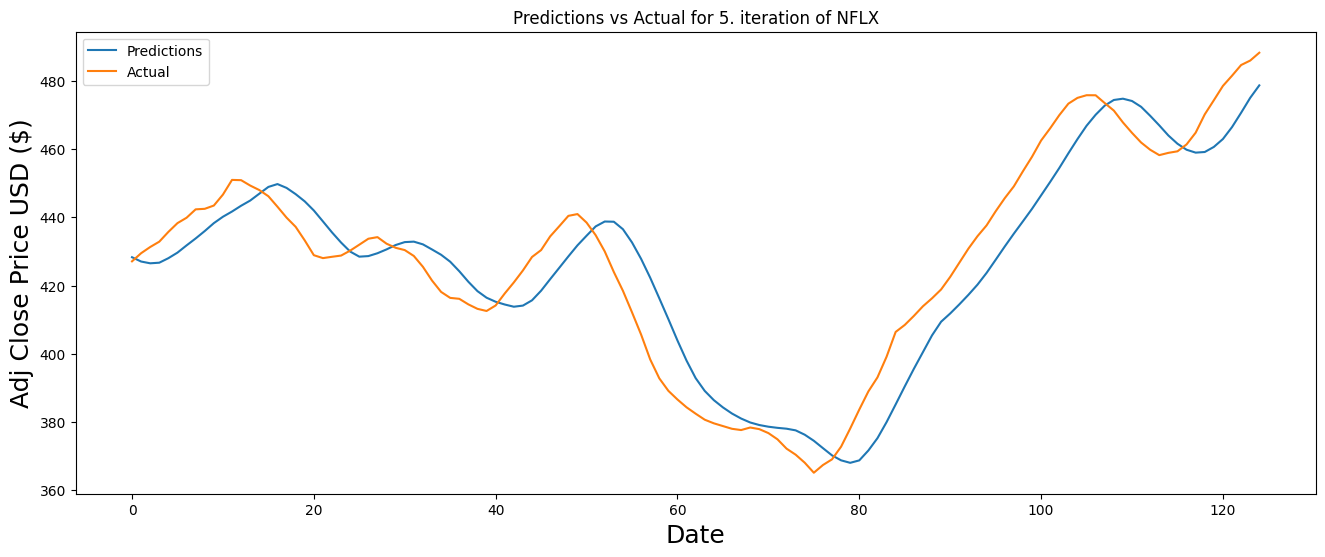

Value of RSME for interval 5 is: 42.8451071918776
Value of MAE for interval 5 is: 34.271110403657005
21/21 [==============================] - 0s 6ms/step


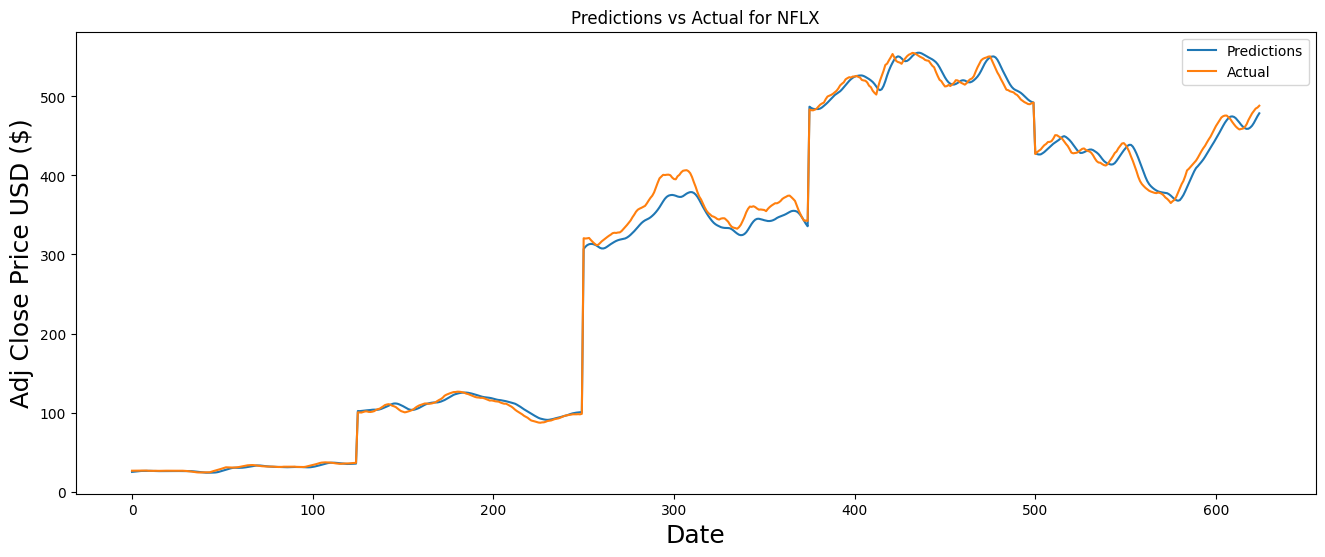

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


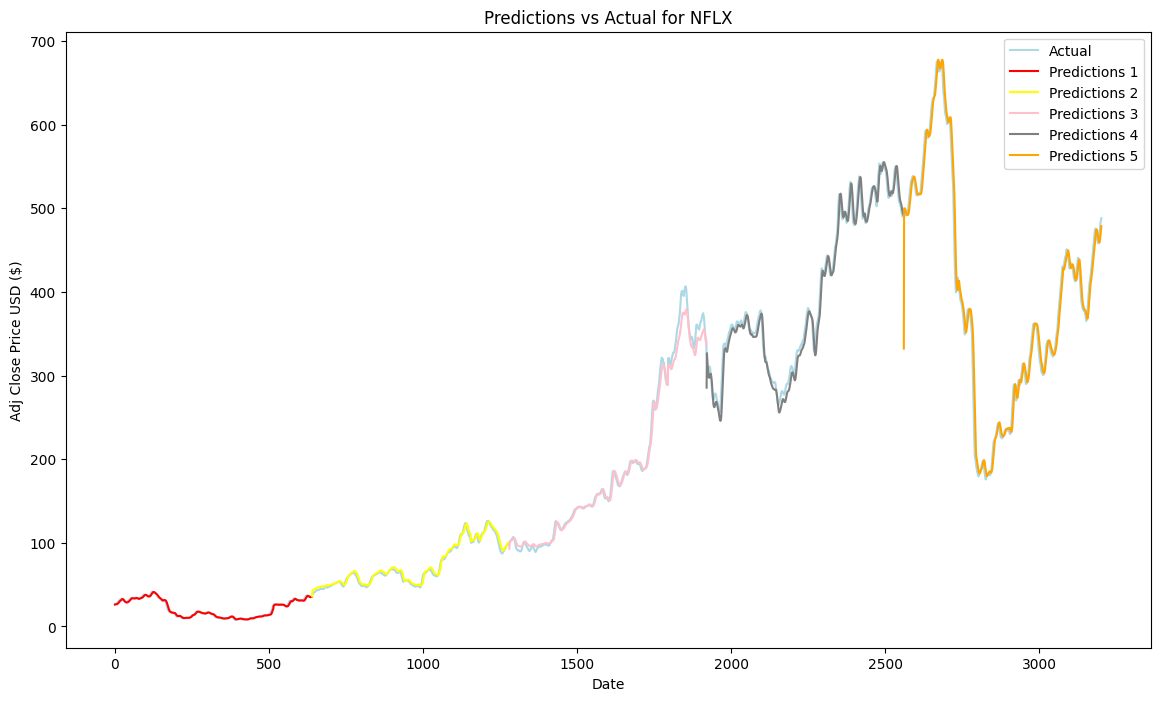

Processing file: NVDA.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/NVDA/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 75)             42300     
                                                                 
 dropout_7 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               104448    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)        

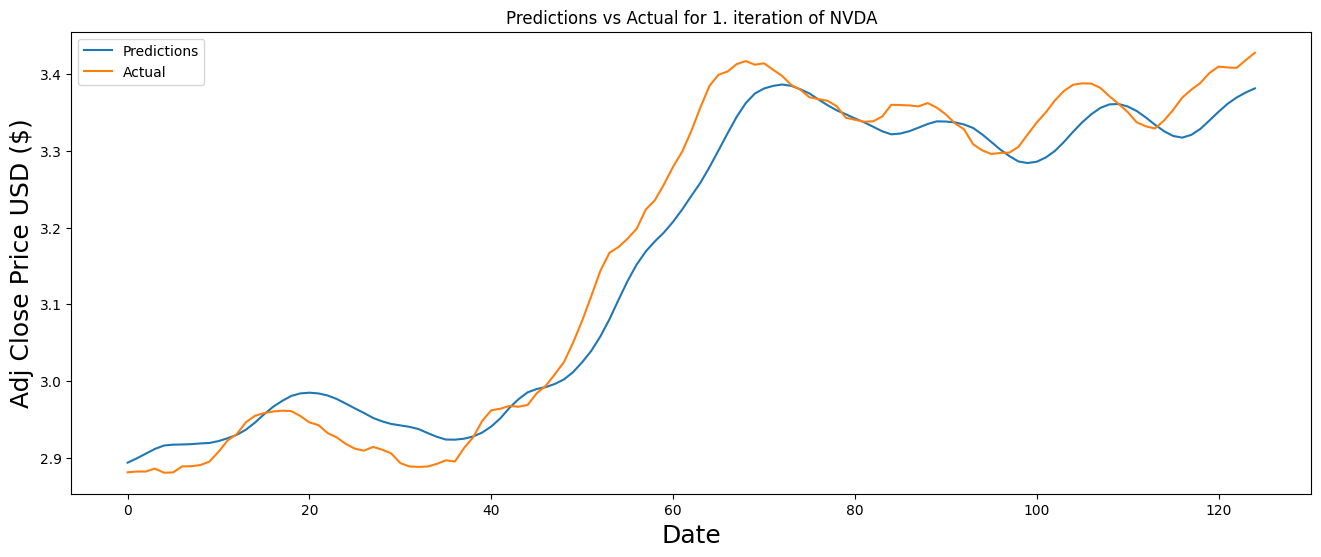

Value of RSME for interval 1 is: 0.2806351636927354
Value of MAE for interval 1 is: 0.21997015906888143
20/20 [==============================] - 0s 5ms/step
checkpoints/NVDA/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 55)             12540     
                                                                 
 dropout_5 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 35)             12740     
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 45)             14580     
                                                                 

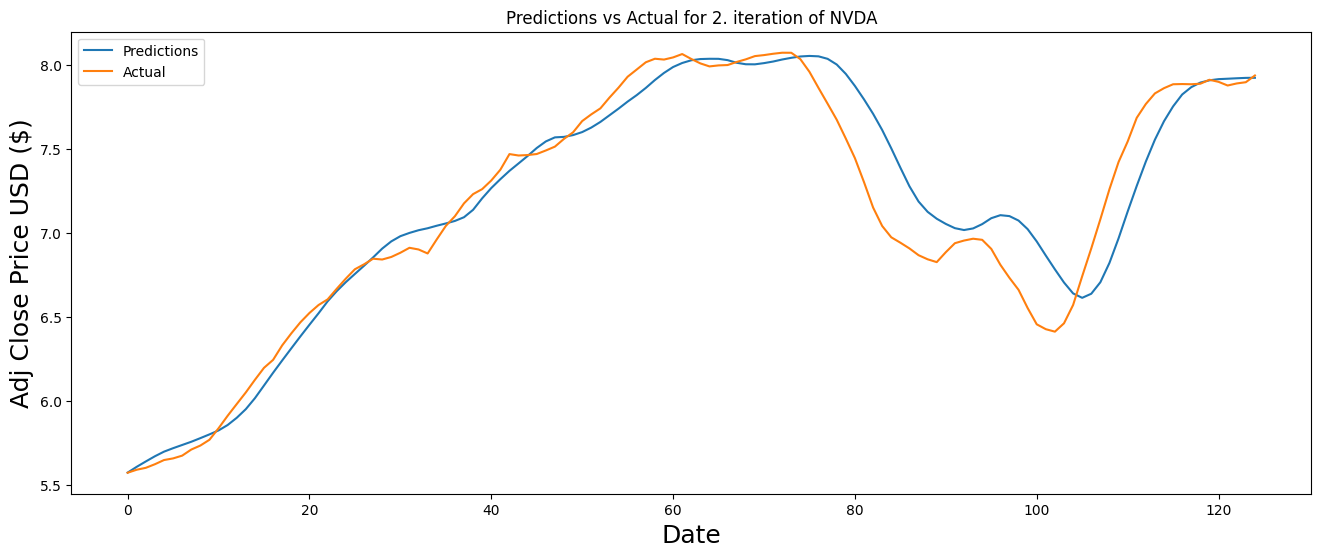

Value of RSME for interval 2 is: 1.0253936057460875
Value of MAE for interval 2 is: 0.8173867082831932
20/20 [==============================] - 0s 6ms/step
checkpoints/NVDA/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 25)             2700      
                                                                 
 dropout_5 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 35)             8540      
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_6 (LSTM)               (None, 160)               125440    
                                                                 


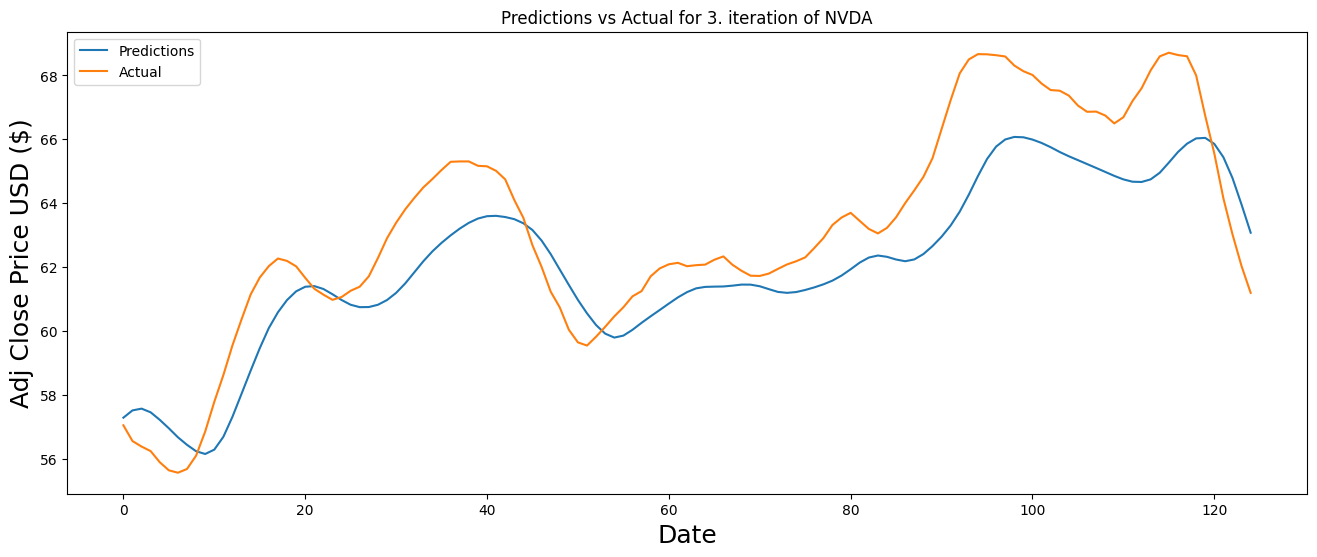

Value of RSME for interval 3 is: 4.38357236026754
Value of MAE for interval 3 is: 3.4938443422088947
20/20 [==============================] - 0s 6ms/step
checkpoints/NVDA/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 35)             5180      
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 45)             14580     
                                                                 
 dropout_7 (Dropout)         (None, 5, 45)             0         
                                                                 
 lstm_5 (LSTM)               (None, 384)               660480    
                                                                 
 d

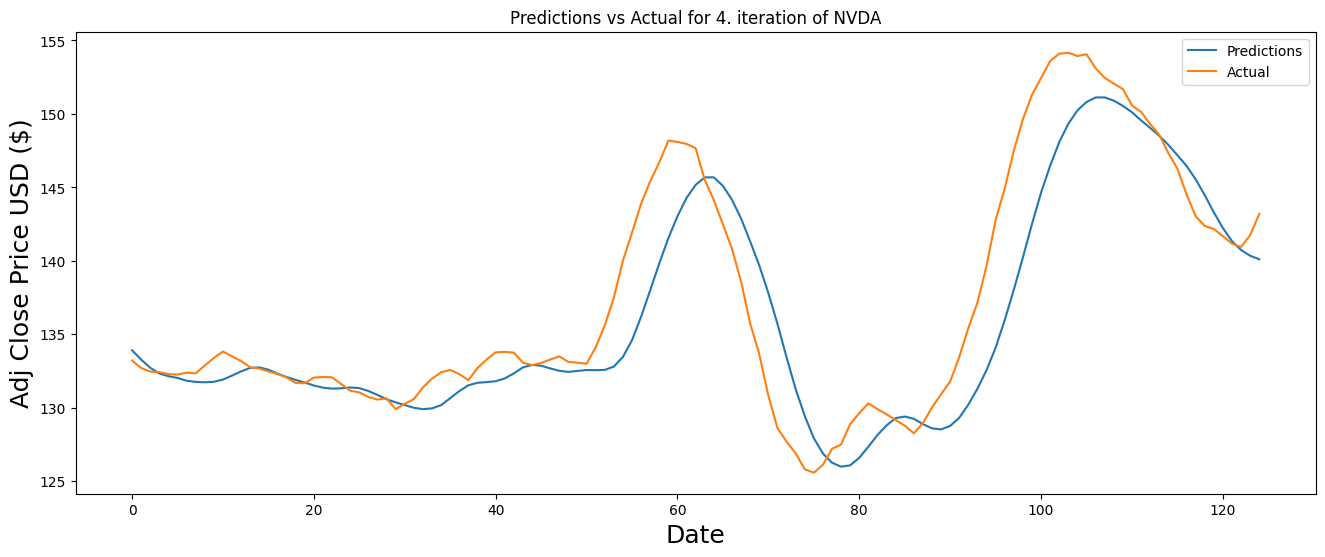

Value of RSME for interval 4 is: 10.70120842724456
Value of MAE for interval 4 is: 8.207596687275428
20/20 [==============================] - 0s 7ms/step
checkpoints/NVDA/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 25)             2700      
                                                                 
 dropout_8 (Dropout)         (None, 5, 25)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 75)             30300     
                                                                 
 dropout_9 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               339968    
                                                                 
 d

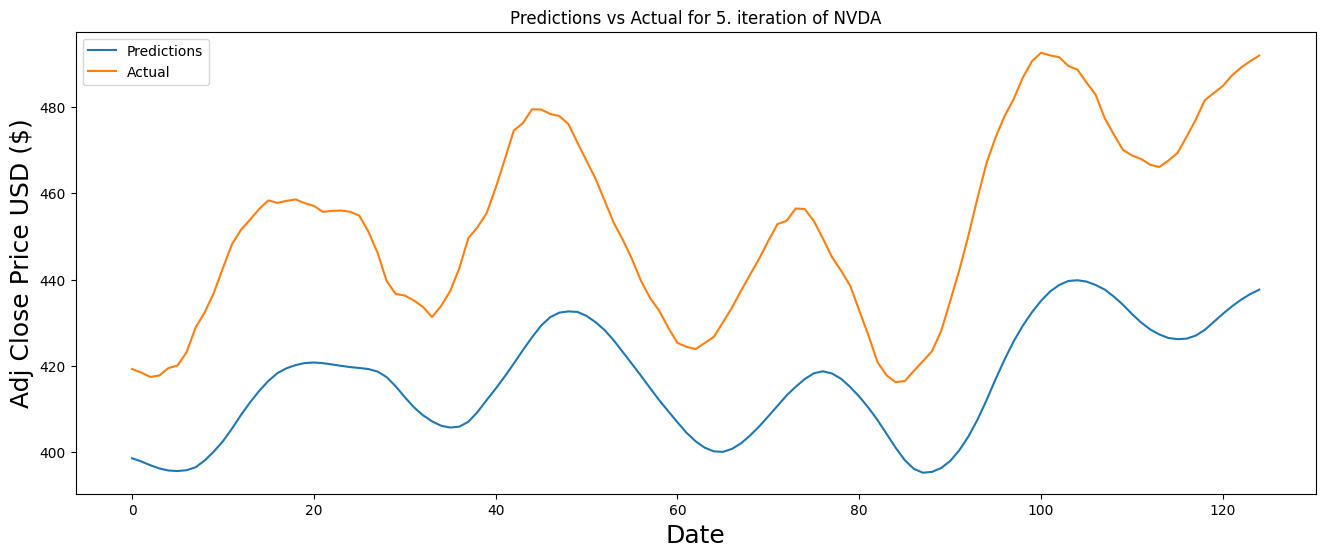

Value of RSME for interval 5 is: 44.565941949924614
Value of MAE for interval 5 is: 37.853295240796804
21/21 [==============================] - 0s 6ms/step


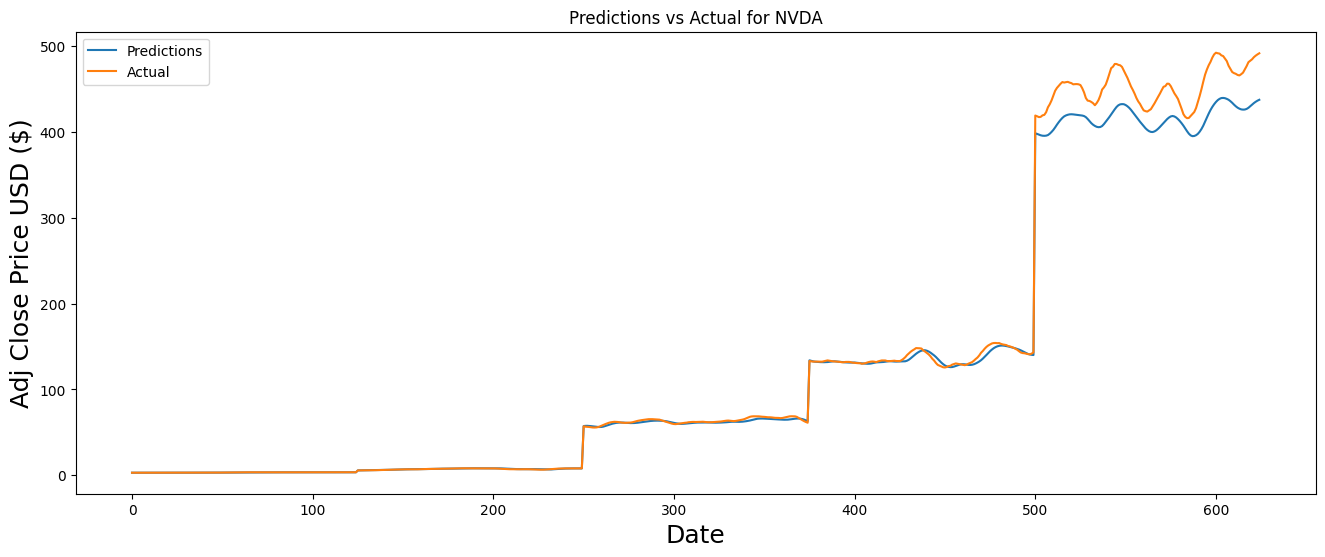

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


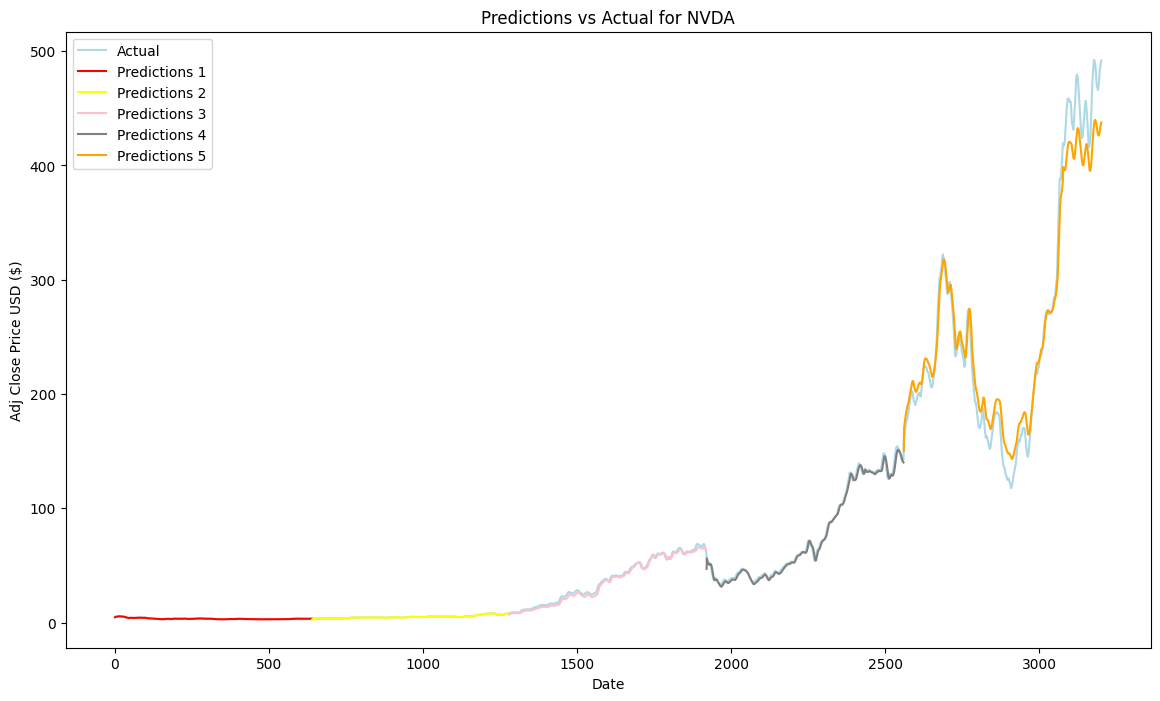

Processing file: TSLA.csv


C:\Users\User\AppData\Local\Temp\ipykernel_88120\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


checkpoints/TSLA/lstm-1.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_5 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 35)             14140     
                                                                 
 dropout_6 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               83968     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)        

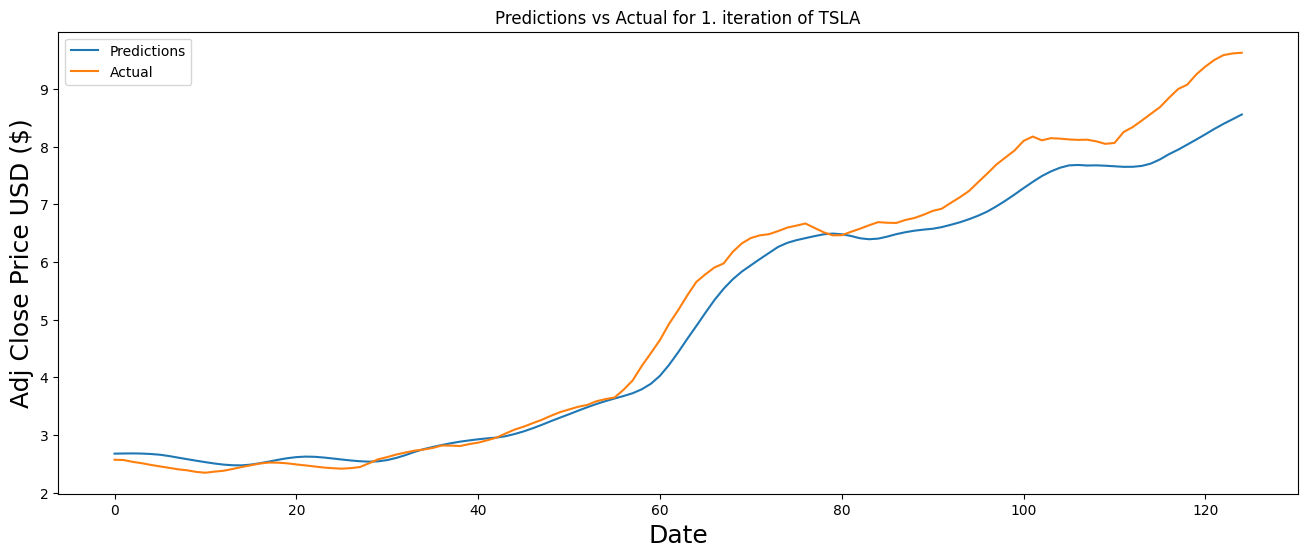

Value of RSME for interval 1 is: 3.2370761700117887
Value of MAE for interval 1 is: 2.5729726247411078
20/20 [==============================] - 0s 6ms/step
checkpoints/TSLA/lstm-2.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 35)             14140     
                                                                 
 dropout_7 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 160)               125440    
                                                                 


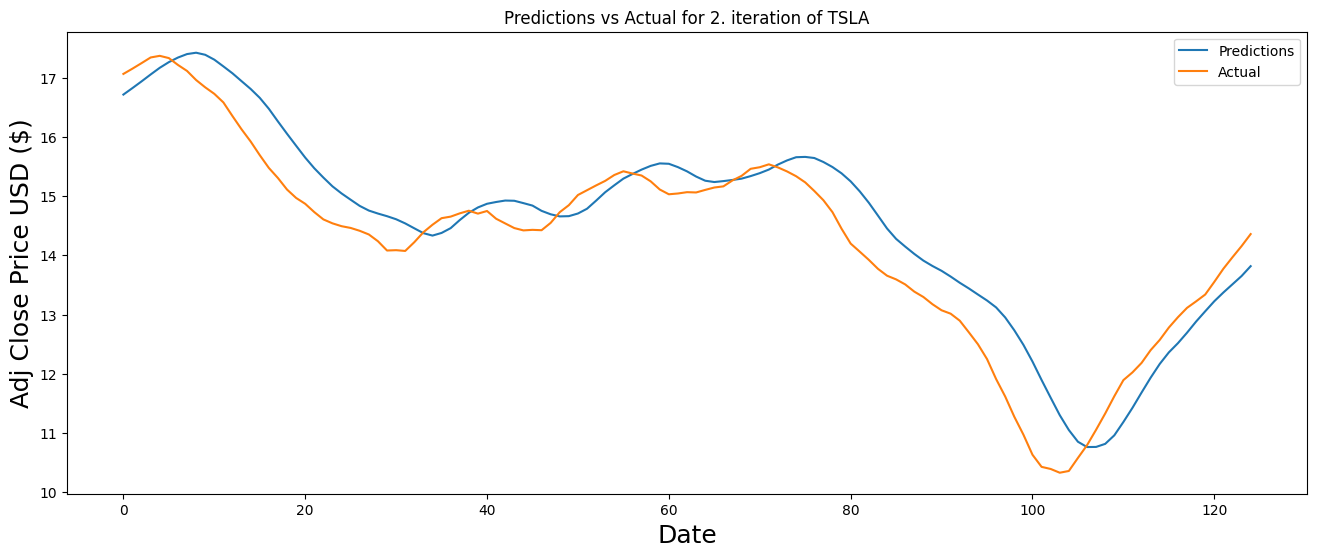

Value of RSME for interval 2 is: 2.366154551067596
Value of MAE for interval 2 is: 1.8510326966909225
20/20 [==============================] - 0s 6ms/step
checkpoints/TSLA/lstm-3.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 75)             23100     
                                                                 
 dropout_8 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 75)             45300     
                                                                 
 dropout_9 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 480)               1067520   
                                                                 
 

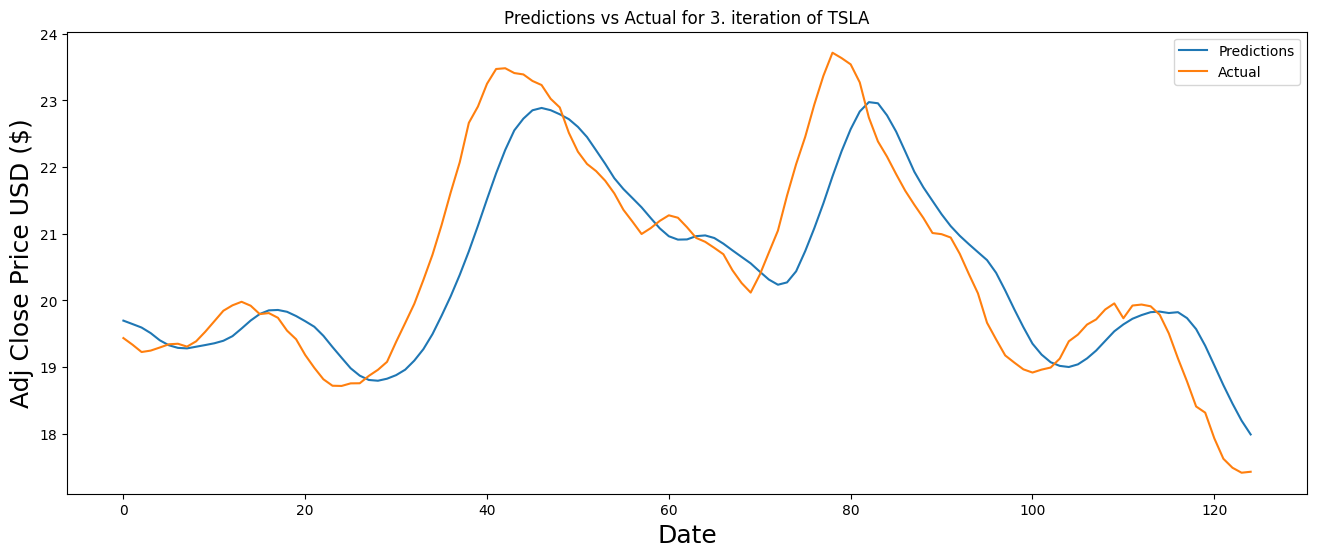

Value of RSME for interval 3 is: 2.025284830295379
Value of MAE for interval 3 is: 1.618673721977811
20/20 [==============================] - 0s 8ms/step
checkpoints/TSLA/lstm-4.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 65)             17420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 65)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 35)             14140     
                                                                 
 dropout_7 (Dropout)         (None, 5, 35)             0         
                                                                 
 lstm_5 (LSTM)               (None, 480)               990720    
                                                                 
 d

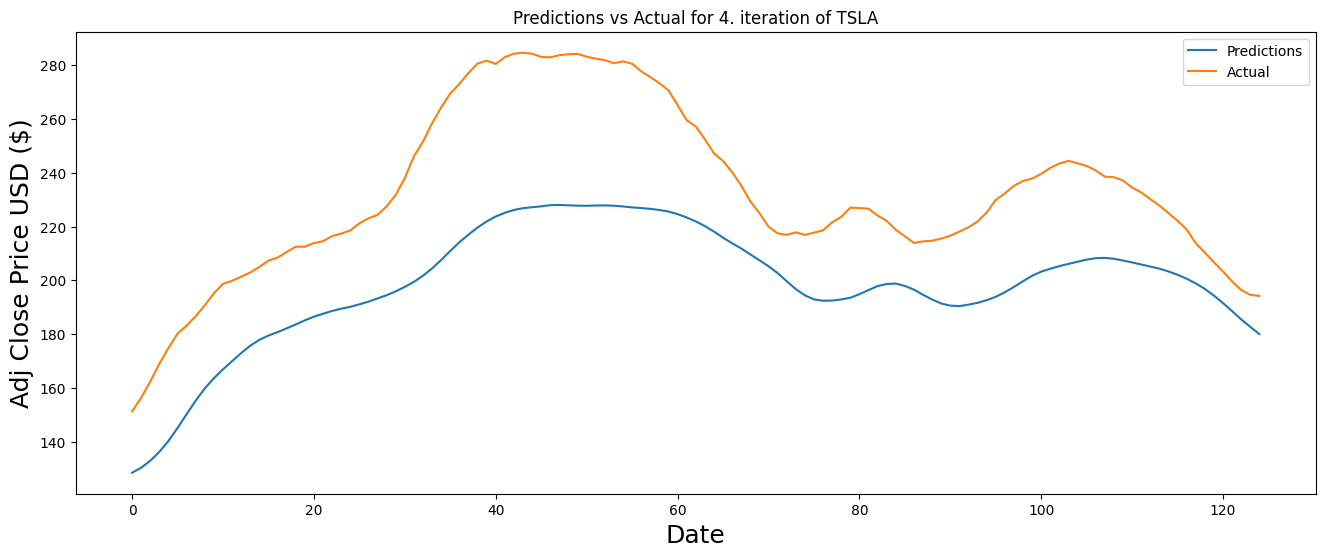

Value of RSME for interval 4 is: 50.83872858535075
Value of MAE for interval 4 is: 40.41436017163154
20/20 [==============================] - 0s 8ms/step
checkpoints/TSLA/lstm-5.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 55)             12540     
                                                                 
 dropout_5 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 55)             24420     
                                                                 
 dropout_6 (Dropout)         (None, 5, 55)             0         
                                                                 
 lstm_5 (LSTM)               (None, 448)               903168    
                                                                 
 d

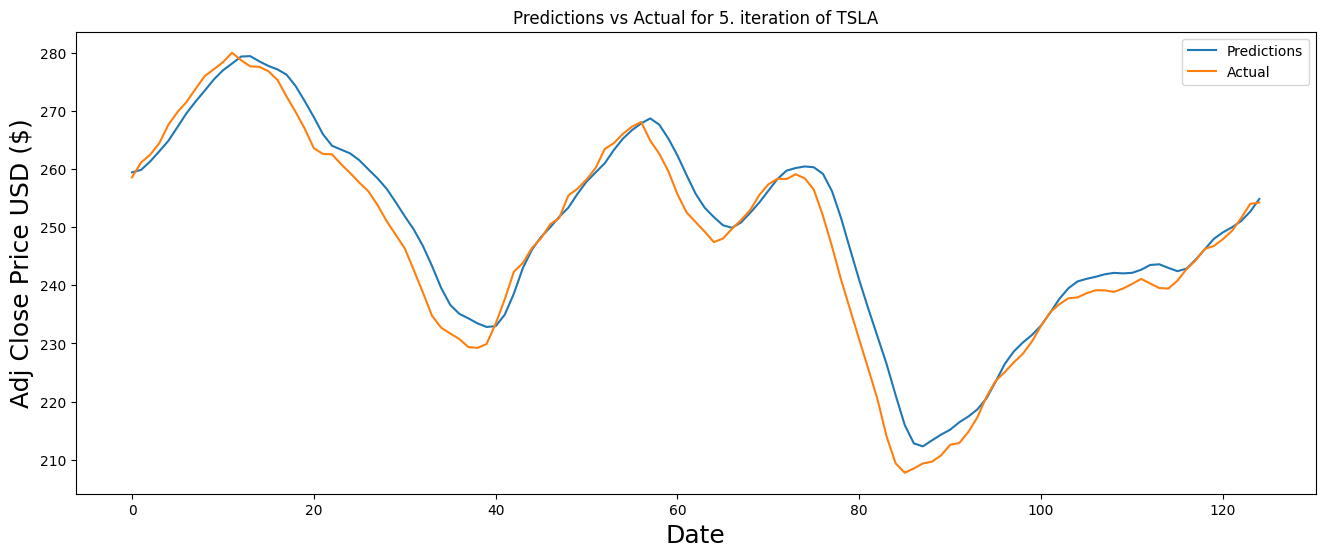

Value of RSME for interval 5 is: 24.66424931022269
Value of MAE for interval 5 is: 19.800672943557405
21/21 [==============================] - 0s 7ms/step


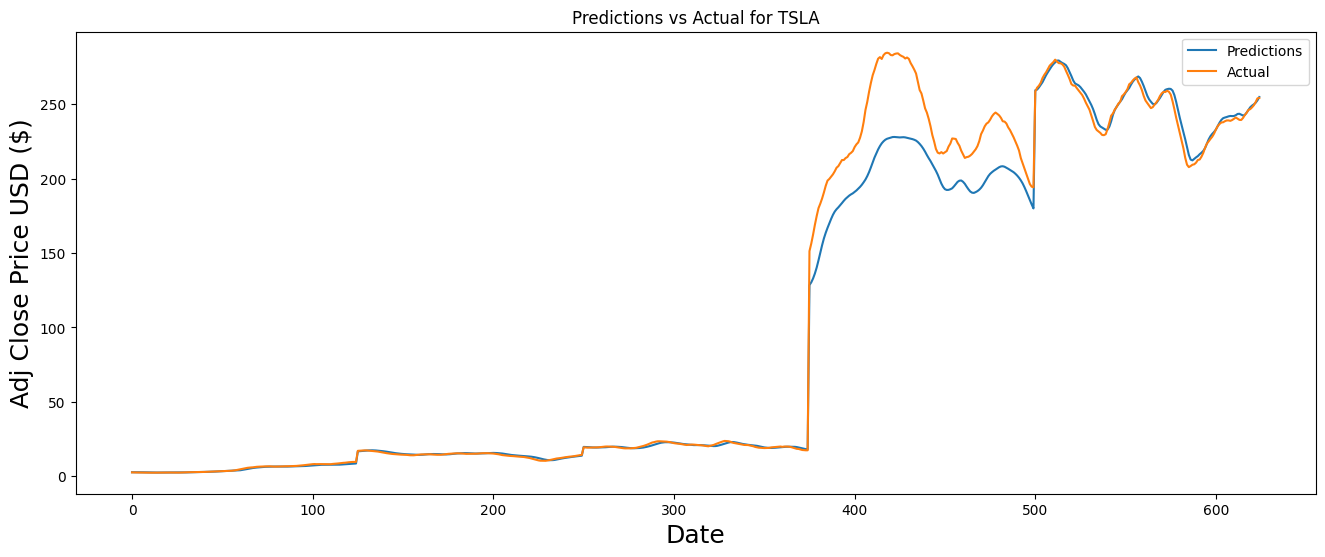

NOTE: The big jumps in the values happen because the intervals have 80% of the training data between them.


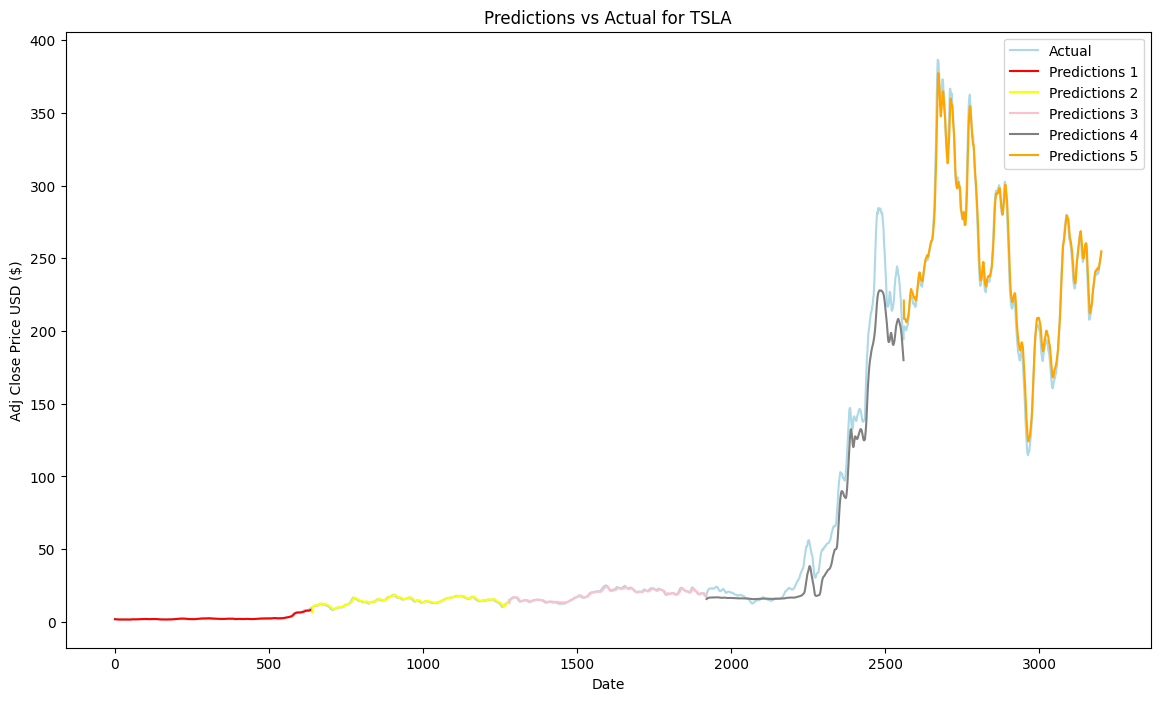

In [16]:
"""
Main function.
"""
files = os.listdir("../../data/processed")

for file in files:
    print("Processing file: " + file)
    lstm_prediction("../../data/processed/" + file)